# <span style="color:green">Analisi su multi asset con loader alternativo ad FFN (fonte dati txt)</span>

Architettura di un Hammer e di una Shooting Star su paniere senza conferma.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

def load_historical_complete_ffn(tickerlist, startdate, enddate):
    inner_tickerlist =  list(tickerlist.split(","))
    input_string = ""
    for ticker in inner_tickerlist:
        if ticker != "^VIX":
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close," +\
                                          ticker + ":Volume,"
        else:
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close,"
    input_string = input_string[:-1]
    print(input_string)
    #'aapl:Open,aapl:High,aapl:Low,aapl:Close'
    dataset = ffn.get(input_string, start = startdate, end = enddate).apply(lambda x: round(x,2))
    dataset.to_csv("universe_data.csv")
    return dataset

def load_historical_from_csv(filename):
    dataset = pd.read_csv(filename, parse_dates=["Date"])
    dataset.index = dataset.Date
    dataset.drop('Date', axis = 1, inplace = True)
    return dataset

def add_indicators(dataframe):
    service = dataframe.copy()
    service.columns = ["open","high","low","close","volume"]
    service["range_perc"] = (service.high - service.low) / service.low * 100
    service["open_pos"] = (service.open - service.low) / (service.high - service.low) * 100
    service["close_pos"] = (service.close - service.low) / (service.high - service.low) * 100
    service["SMA20"] = service.close.rolling(20).mean()
    service["STD20"] = service.close.rolling(20).std()
    service["BBU"] = service.SMA20 + 2 * service.STD20
    service["BBL"] = service.SMA20 - 2 * service.STD20
    service.dropna(inplace = True)
    #print(service.head(10))
    return service

def pattern_stats(dataframe,pattern,direction,delay,ticker):
    """
    Function to calculate pattern stats
    """
    service = dataframe.copy()
    dates = service[pattern == True].index
    occurrences = service[pattern == True].count()[0]
    print("Occurrences:", occurrences, "\n")
    print(dates,"\n")
    results = []
    for i in range(0, delay):
        label = "st" + str(i + 1)
        if direction == "long":
            service[label] = np.where(pattern.shift(1) == True, service.close.shift(-i) - service.open, np.nan)
        else:
            service[label] = np.where(pattern.shift(1) == True, -service.close.shift(-i) + service.open, np.nan)
        profit = round(service[label].sum(),2)
        avg_profit = round(profit / occurrences, 2)
        winning_trades = service[service[label] > 0].count()[0]
        loosing_trades = service[service[label] <= 0].count()[0]
        print("After:", i + 1,  "days:", profit, "average of", avg_profit, "with", winning_trades, "winning trades and", loosing_trades, "loosing trades")
        results.append(profit)
    plotting_results = pd.DataFrame(results, columns = ["results"], 
                                    index = range(1, delay + 1))
    plotting_results.plot(figsize = [14,8], color = "blue").grid()
    plt.title(ticker + " post pattern inertia")
    plt.show()
    return dates, plotting_results

def plot_patterns(dataframe,results):
    """
    Function that plots every single pattern occurrence
    """
    for date in results:
        single_case = dataframe[(dataframe.index >= (date)) & \
                                (dataframe.index <= (date + pd.Timedelta(days = 20)))]    
        graph_title = ticker + " from " + str(single_case.index[0]) + " - Powered by Gandalf Project R&D"

        #up_colors = np.where(single_case.index == date, "yellow", "green")
        #down_colors = np.where(single_case.index == date, "yellow", "red")

        single_case.iplot(kind = 'candle',theme = 'white',
                          up_color = "green", down_color = "red",
                          title = graph_title, xTitle = "Time", yTitle = "Prices")
    return

def create_asset_dataset(matrix):
    """
    Function that slices the original dataframe
    for each single asset
    """
    service = pd.DataFrame(index = matrix.index)
    for column in matrix.columns:
        #print(column)
        if ticker.lower() in column:
            service[column] = matrix[column]
    service = add_indicators(service)
    #print(service)
    return service

def positive_effect(basket_results):
    export = []
    for i in range(1, len(basket_results) + 1):
        positive = []
        for column in basket_results.columns:
            if basket_results[column][i] > 0:
                positive.append(column)
        export.append(positive)
        print("Positive inertia after", i, "bars:", positive)
    return export

### Funzioni aggiunte

In [7]:
def load_data_daily_slim(folder,filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    path = folder + filename
    data = pd.read_csv(path, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    
    return data

def load_multiple_data_daily(folder,asset_filelist,start_date):
        
    i = 1
    # First of all we create aligned dataframe with all historical data
    for file in asset_filelist:
        ticker = file.split("_")[0].lower()
        service = load_data_daily_slim(folder,file)
        new_col_names = []
        [new_col_names.append(ticker + "_" + col) for col in service.columns]
        service.columns = new_col_names 
        if i == 1:
            dataset = service
        else:
            dataset = pd.concat([dataset, service], axis = 1).dropna()
        i += 1
        
    dataset = dataset[dataset.index >= pd.to_datetime(start_date, format='%Y-%m-%d', errors='ignore')]

    return dataset

In [37]:
load_new_data = True

folder = "data/"

asset_filelist = ["AXP_daily.txt",
                  "AAPL_daily.txt",
                  "BA_daily.txt",
                  "CAT_daily.txt",
                  "CVX_daily.txt",
                  "CSCO_daily.txt",
                  "DIS_daily.txt",
                  "KO_daily.txt",
                  "GS_daily.txt",
                  "HD_daily.txt",
                  "IBM_daily.txt",
                  "INTC_daily.txt",
                  "JNJ_daily.txt",
                  "JPM_daily.txt",
                  "MCD_daily.txt",
                  "MMM_daily.txt",
                  "MSFT_daily.txt",
                  "NKE_daily.txt",
                  "PFE_daily.txt",
                  "XOM_daily.txt"]

start_date = "2000-01-01"

days_after = 10

show_patterns = False

if load_new_data == True:
    matrix = load_multiple_data_daily(folder,asset_filelist,start_date)
else:
    matrix = load_historical_from_csv("universe_data.csv")
    #print(matrix)
    
matrix.to_csv("universe_data.csv")
#matrix = dataset.filter(regex='close')
matrix.head(10)

,axp_open,axp_high,axp_low,axp_close,axp_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,...,pfe_open,pfe_high,pfe_low,pfe_close,pfe_volume,xom_open,xom_high,xom_low,xom_close,xom_volume
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,48.00,48.00,45.52,45.97,6470290,0.94,1.00,0.91,1.00,540948800,...,30.39,30.69,29.98,30.45,12880861,39.75,40.38,38.94,39.16,13454200
2000-01-04,45.32,45.48,43.51,44.15,10368778,0.97,0.99,0.90,0.92,506665600,...,29.62,29.86,29.03,29.09,14216587,38.69,39.09,38.25,38.41,14511200
2000-01-05,43.91,44.68,42.96,43.02,8597922,0.93,0.99,0.92,0.93,777795200,...,29.27,30.22,29.21,29.56,12995319,39.00,40.88,38.91,40.50,17485000
2000-01-06,42.45,44.46,42.45,43.84,10990480,0.95,0.96,0.85,0.85,767984000,...,29.62,31.05,29.56,30.63,11126442,40.31,42.91,40.09,42.59,19462000
2000-01-07,43.99,44.79,43.33,44.48,6015838,0.86,0.90,0.85,0.89,460992000,...,32.23,33.06,30.63,32.70,17978287,42.97,43.13,42.00,42.47,16770800
2000-01-10,44.64,45.68,44.31,45.10,4906097,0.91,0.91,0.85,0.87,505064000,...,33.18,33.18,32.29,32.64,10423978,42.09,42.31,41.78,41.88,8545400
2000-01-11,45.04,46.68,44.86,45.52,7159851,0.86,0.89,0.81,0.83,440977600,...,32.47,33.18,32.23,32.23,9755482,41.88,42.63,41.81,42.00,8731600
2000-01-12,45.50,46.36,44.77,45.28,5816715,0.85,0.85,0.77,0.78,975889600,...,32.70,33.89,32.64,33.30,11433526,41.63,42.19,41.41,41.75,10306800
2000-01-13,45.66,46.17,45.01,45.52,5830767,0.84,0.88,0.83,0.86,1035339200,...,33.12,35.19,32.82,35.07,27729761,41.75,43.00,41.56,42.72,12056000


# <span style="color:green">Esempio pattern "Hammer"</span>

In [38]:
asset_filelist

['AXP_daily.txt',
 'AAPL_daily.txt',
 'BA_daily.txt',
 'CAT_daily.txt',
 'CVX_daily.txt',
 'CSCO_daily.txt',
 'DIS_daily.txt',
 'KO_daily.txt',
 'GS_daily.txt',
 'HD_daily.txt',
 'IBM_daily.txt',
 'INTC_daily.txt',
 'JNJ_daily.txt',
 'JPM_daily.txt',
 'MCD_daily.txt',
 'MMM_daily.txt',
 'MSFT_daily.txt',
 'NKE_daily.txt',
 'PFE_daily.txt',
 'XOM_daily.txt']

In [39]:
tickerlist = []
for el in asset_filelist:
    tickerlist.append(el.split("_")[0])
tickerlist

['AXP',
 'AAPL',
 'BA',
 'CAT',
 'CVX',
 'CSCO',
 'DIS',
 'KO',
 'GS',
 'HD',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'MCD',
 'MMM',
 'MSFT',
 'NKE',
 'PFE',
 'XOM']

Pattern analysis on: AXP

Occurrences: 25 

DatetimeIndex(['2000-11-21', '2001-02-23', '2001-02-26', '2002-01-30',
               '2002-09-25', '2002-12-31', '2003-01-23', '2003-02-13',
               '2004-12-09', '2005-08-31', '2005-10-13', '2007-10-24',
               '2007-12-13', '2009-02-12', '2009-06-23', '2010-05-17',
               '2011-10-05', '2012-05-23', '2013-04-17', '2014-07-28',
               '2015-07-07', '2017-05-31', '2018-12-10', '2020-10-30',
               '2021-08-03'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -1.46 average of -0.06 with 13 winning trades and 12 loosing trades
After: 2 days: 3.96 average of 0.16 with 13 winning trades and 12 loosing trades
After: 3 days: 5.1 average of 0.2 with 14 winning trades and 11 loosing trades
After: 4 days: 9.76 average of 0.39 with 15 winning trades and 10 loosing trades
After: 5 days: 1.0 average of 0.04 with 12 winning trades and 13 loosing trades
After: 6 days: 14.64 average of 

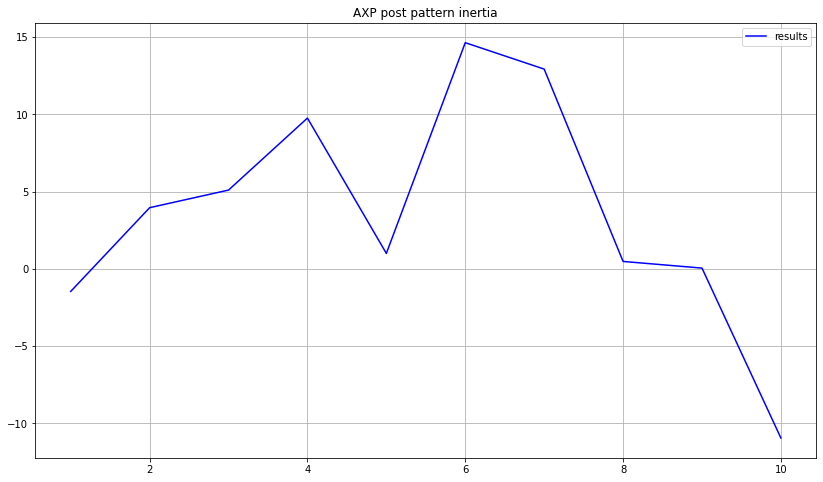


Pattern analysis on: AAPL

Occurrences: 24 

DatetimeIndex(['2001-08-16', '2001-08-30', '2002-06-04', '2002-06-05',
               '2002-06-20', '2002-12-04', '2003-01-24', '2003-11-17',
               '2003-12-17', '2005-05-11', '2007-08-01', '2008-07-21',
               '2010-05-06', '2010-08-27', '2012-10-09', '2012-11-16',
               '2015-07-07', '2015-10-01', '2015-12-16', '2015-12-21',
               '2018-02-09', '2019-05-10', '2020-03-23', '2021-02-24'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -0.1 average of -0.0 with 9 winning trades and 15 loosing trades
After: 2 days: 0.11 average of 0.0 with 12 winning trades and 12 loosing trades
After: 3 days: 12.61 average of 0.53 with 14 winning trades and 10 loosing trades
After: 4 days: 9.48 average of 0.4 with 11 winning trades and 13 loosing trades
After: 5 days: 9.26 average of 0.39 with 16 winning trades and 8 loosing trades
After: 6 days: 5.37 average of 0.22 with 14 winning trades an

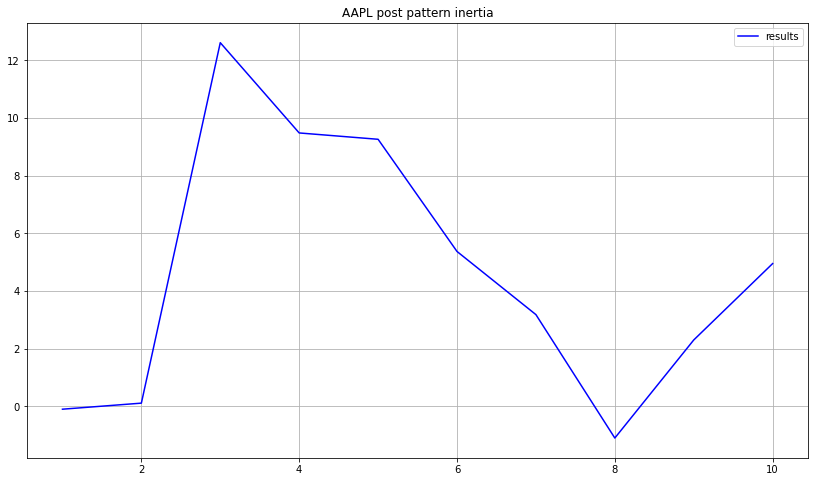


Pattern analysis on: BA

Occurrences: 32 

DatetimeIndex(['2000-12-21', '2001-01-09', '2001-01-30', '2001-11-12',
               '2003-03-07', '2003-07-18', '2003-11-26', '2004-10-04',
               '2004-10-25', '2006-06-08', '2008-03-04', '2009-02-12',
               '2011-06-03', '2013-06-21', '2014-02-05', '2014-10-15',
               '2015-08-12', '2015-08-26', '2015-09-24', '2016-01-06',
               '2016-01-12', '2016-01-14', '2016-06-01', '2016-09-01',
               '2018-02-09', '2018-03-16', '2018-03-28', '2019-06-03',
               '2020-03-10', '2020-09-04', '2021-01-25', '2021-05-04'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -28.99 average of -0.91 with 16 winning trades and 16 loosing trades
After: 2 days: -67.18 average of -2.1 with 15 winning trades and 17 loosing trades
After: 3 days: -39.99 average of -1.25 with 15 winning trades and 17 loosing trades
After: 4 days: -73.28 average of -2.29 with 17 winning trades and 15 loo

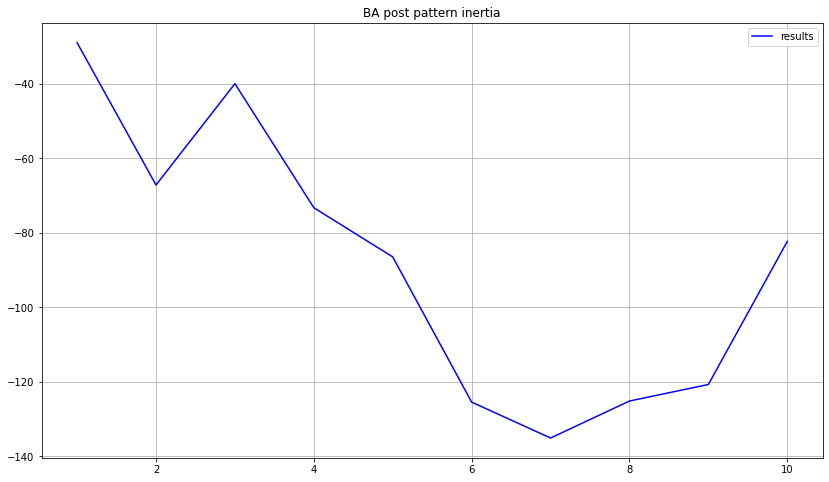


Pattern analysis on: CAT

Occurrences: 24 

DatetimeIndex(['2001-11-01', '2002-05-30', '2002-06-12', '2002-07-15',
               '2002-09-04', '2002-09-06', '2003-01-23', '2003-09-10',
               '2007-03-01', '2008-01-09', '2008-06-30', '2008-09-18',
               '2009-05-28', '2010-10-27', '2011-08-05', '2012-05-08',
               '2014-09-11', '2014-09-18', '2015-01-29', '2015-08-26',
               '2018-02-09', '2019-10-03', '2020-03-13', '2020-05-13'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 3.94 average of 0.16 with 17 winning trades and 7 loosing trades
After: 2 days: 12.96 average of 0.54 with 12 winning trades and 12 loosing trades
After: 3 days: 22.05 average of 0.92 with 13 winning trades and 11 loosing trades
After: 4 days: 21.88 average of 0.91 with 13 winning trades and 11 loosing trades
After: 5 days: 17.39 average of 0.72 with 14 winning trades and 10 loosing trades
After: 6 days: 18.29 average of 0.76 with 12 winning tra

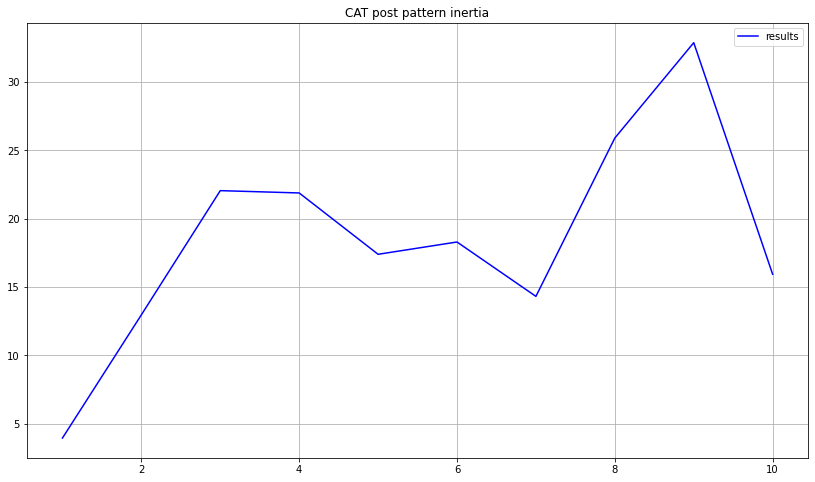


Pattern analysis on: CVX

Occurrences: 33 

DatetimeIndex(['2000-06-02', '2001-07-02', '2002-06-05', '2002-09-04',
               '2003-04-10', '2003-04-25', '2003-07-01', '2003-07-02',
               '2005-03-30', '2007-08-06', '2008-10-06', '2009-02-12',
               '2010-05-17', '2011-04-18', '2011-06-23', '2012-05-23',
               '2013-06-21', '2013-10-02', '2014-08-04', '2014-09-29',
               '2014-10-03', '2016-01-12', '2016-01-20', '2016-08-02',
               '2018-01-31', '2018-02-01', '2018-02-09', '2018-07-18',
               '2018-12-06', '2018-12-10', '2019-10-04', '2020-01-09',
               '2020-03-10'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -20.89 average of -0.63 with 12 winning trades and 21 loosing trades
After: 2 days: -34.89 average of -1.06 with 11 winning trades and 22 loosing trades
After: 3 days: -45.52 average of -1.38 with 16 winning trades and 17 loosing trades
After: 4 days: -61.47 average of -1.86 wi

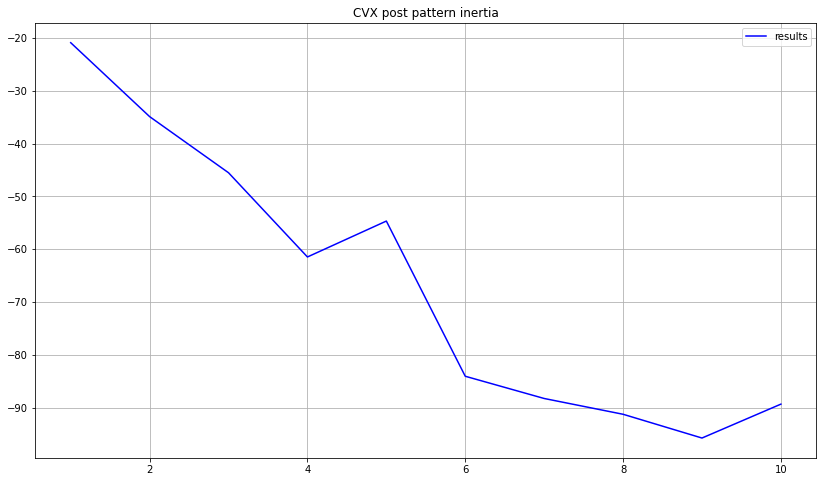


Pattern analysis on: CSCO

Occurrences: 25 

DatetimeIndex(['2000-05-15', '2001-02-05', '2001-09-19', '2002-02-22',
               '2002-06-27', '2003-02-04', '2004-04-21', '2004-09-28',
               '2004-10-26', '2005-06-15', '2007-10-23', '2007-10-24',
               '2008-11-18', '2009-07-13', '2010-05-17', '2011-05-18',
               '2013-02-14', '2013-10-24', '2014-10-08', '2016-01-04',
               '2017-06-16', '2018-04-03', '2018-07-23', '2019-10-10',
               '2019-11-18'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 1.39 average of 0.06 with 14 winning trades and 11 loosing trades
After: 2 days: -6.55 average of -0.26 with 11 winning trades and 14 loosing trades
After: 3 days: -11.59 average of -0.46 with 12 winning trades and 13 loosing trades
After: 4 days: -13.08 average of -0.52 with 13 winning trades and 12 loosing trades
After: 5 days: -6.04 average of -0.24 with 13 winning trades and 12 loosing trades
After: 6 days: -11.

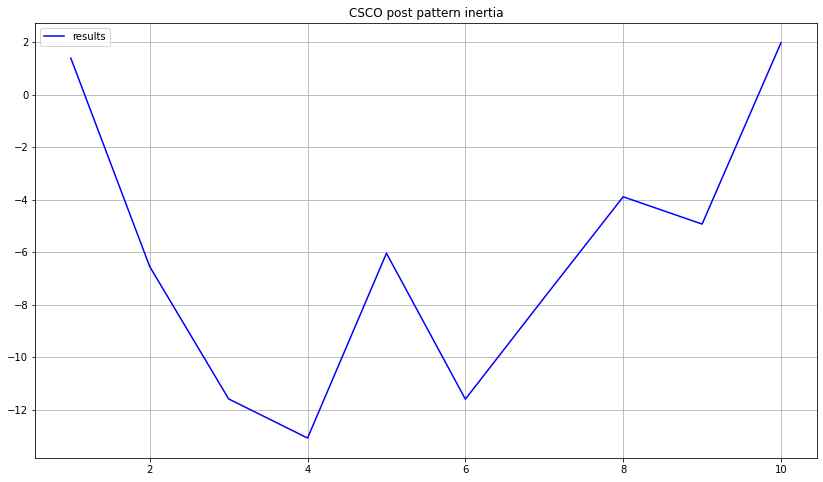


Pattern analysis on: DIS

Occurrences: 35 

DatetimeIndex(['2000-05-22', '2001-03-06', '2001-06-27', '2002-01-30',
               '2004-04-01', '2004-09-29', '2005-05-13', '2005-08-31',
               '2007-07-30', '2008-07-01', '2008-07-08', '2008-09-05',
               '2010-01-28', '2010-05-17', '2013-06-06', '2014-02-04',
               '2014-03-27', '2014-04-08', '2014-04-14', '2014-04-15',
               '2015-01-29', '2015-08-12', '2016-01-04', '2016-02-08',
               '2016-02-12', '2016-05-19', '2017-05-11', '2018-12-10',
               '2019-02-07', '2019-08-08', '2020-03-02', '2020-03-13',
               '2020-03-18', '2021-01-25', '2021-05-11'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 1.14 average of 0.03 with 18 winning trades and 17 loosing trades
After: 2 days: -13.56 average of -0.39 with 15 winning trades and 20 loosing trades
After: 3 days: -13.2 average of -0.38 with 21 winning trades and 14 loosing trades
After: 4 days: -1

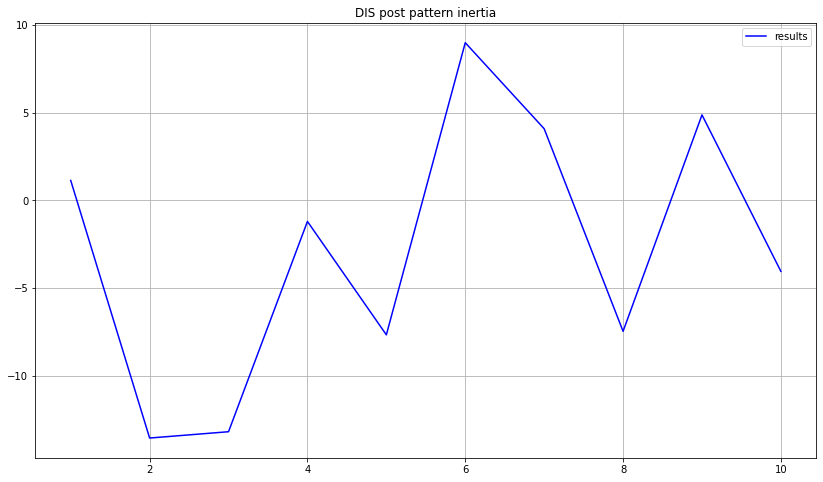


Pattern analysis on: KO

Occurrences: 29 

DatetimeIndex(['2000-02-23', '2000-08-23', '2001-03-22', '2001-05-15',
               '2001-06-13', '2001-09-27', '2002-12-30', '2003-04-24',
               '2004-03-12', '2004-05-12', '2004-11-22', '2005-03-21',
               '2005-10-19', '2006-06-15', '2006-12-01', '2009-01-21',
               '2009-02-02', '2010-01-25', '2011-10-05', '2013-05-23',
               '2013-07-26', '2013-10-01', '2015-08-26', '2016-01-20',
               '2016-06-28', '2018-12-10', '2020-03-10', '2020-03-11',
               '2020-03-18'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -3.89 average of -0.13 with 11 winning trades and 18 loosing trades
After: 2 days: -10.87 average of -0.37 with 11 winning trades and 18 loosing trades
After: 3 days: -11.64 average of -0.4 with 15 winning trades and 14 loosing trades
After: 4 days: -12.06 average of -0.42 with 14 winning trades and 15 loosing trades
After: 5 days: -14.07 average o

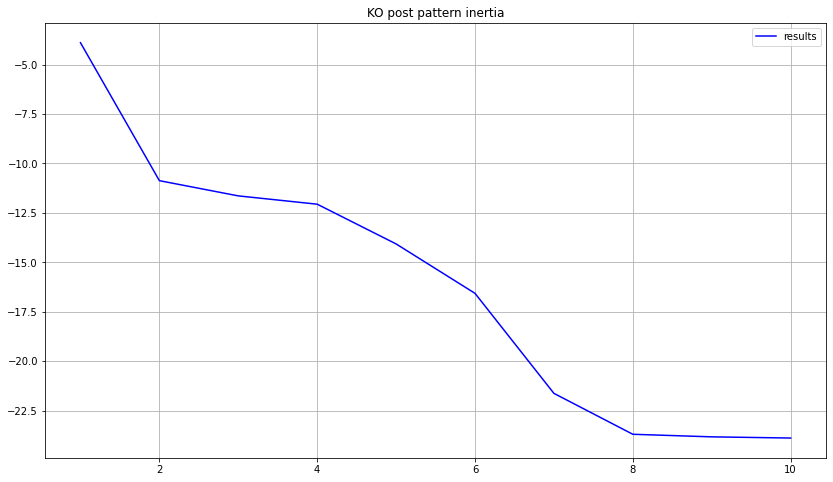


Pattern analysis on: GS

Occurrences: 27 

DatetimeIndex(['2000-11-09', '2001-02-23', '2002-02-22', '2002-06-12',
               '2002-09-25', '2003-03-12', '2003-05-20', '2004-05-06',
               '2004-10-20', '2005-01-26', '2008-02-13', '2008-10-28',
               '2011-03-17', '2011-08-09', '2014-10-15', '2014-12-01',
               '2015-07-07', '2016-02-03', '2016-09-28', '2018-02-09',
               '2018-05-03', '2018-05-30', '2019-03-07', '2019-05-23',
               '2019-05-29', '2020-10-30', '2021-07-19'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 22.63 average of 0.84 with 18 winning trades and 9 loosing trades
After: 2 days: 47.43 average of 1.76 with 18 winning trades and 9 loosing trades
After: 3 days: 50.21 average of 1.86 with 16 winning trades and 11 loosing trades
After: 4 days: 90.62 average of 3.36 with 19 winning trades and 8 loosing trades
After: 5 days: 99.77 average of 3.7 with 20 winning trades and 7 loosing trades
Aft

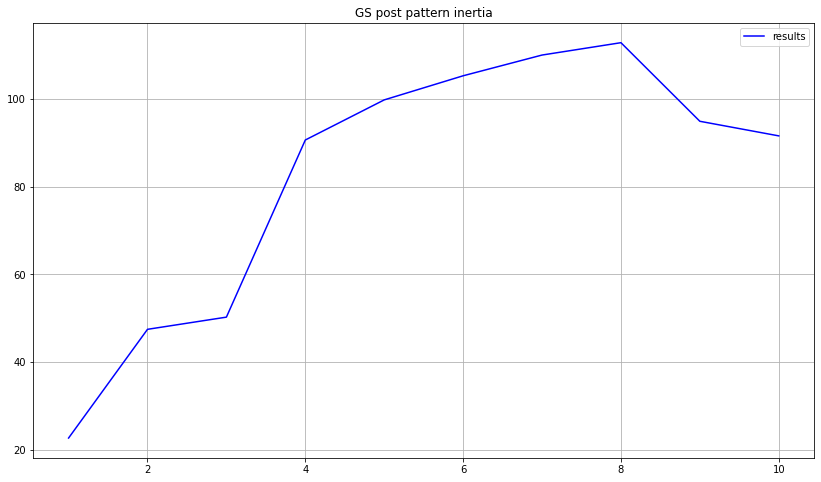


Pattern analysis on: HD

Occurrences: 25 

DatetimeIndex(['2000-01-31', '2001-03-22', '2001-08-10', '2002-05-22',
               '2002-12-30', '2003-09-12', '2004-05-11', '2004-05-12',
               '2005-02-24', '2005-04-29', '2007-03-14', '2007-09-25',
               '2007-10-24', '2008-01-09', '2008-11-21', '2009-01-21',
               '2009-05-08', '2010-05-19', '2014-04-15', '2014-05-15',
               '2016-10-19', '2018-02-09', '2020-09-21', '2021-03-05',
               '2021-06-14'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 9.05 average of 0.36 with 17 winning trades and 8 loosing trades
After: 2 days: 9.23 average of 0.37 with 16 winning trades and 9 loosing trades
After: 3 days: 14.0 average of 0.56 with 18 winning trades and 7 loosing trades
After: 4 days: 18.93 average of 0.76 with 17 winning trades and 8 loosing trades
After: 5 days: 29.51 average of 1.18 with 19 winning trades and 6 loosing trades
After: 6 days: 45.57 average of 1.

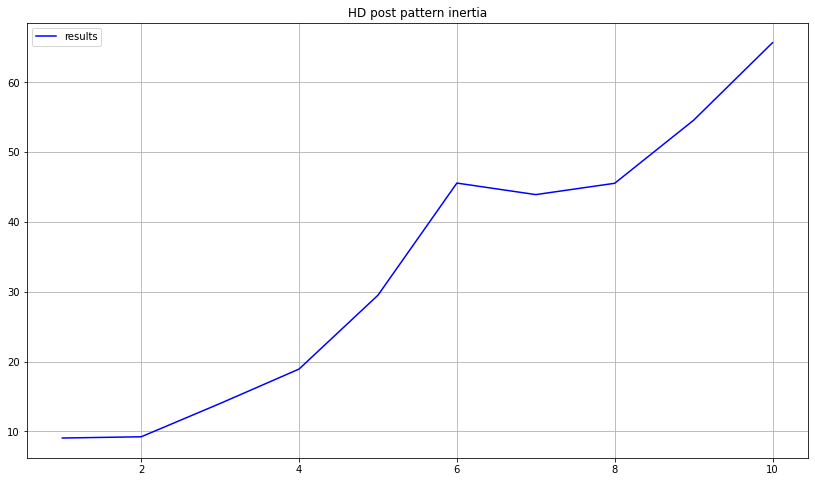


Pattern analysis on: IBM

Occurrences: 31 

DatetimeIndex(['2000-10-11', '2001-02-26', '2001-09-19', '2002-06-07',
               '2003-03-12', '2004-05-12', '2005-01-12', '2008-09-03',
               '2008-09-30', '2009-02-25', '2009-09-03', '2011-08-05',
               '2012-01-13', '2012-05-23', '2013-04-05', '2013-06-25',
               '2014-05-07', '2015-02-02', '2015-06-09', '2015-07-07',
               '2015-12-21', '2016-10-13', '2017-07-11', '2017-07-27',
               '2019-05-10', '2019-08-07', '2019-10-03', '2019-12-03',
               '2020-03-10', '2020-03-13', '2020-09-21'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -17.26 average of -0.56 with 14 winning trades and 17 loosing trades
After: 2 days: -29.44 average of -0.95 with 14 winning trades and 17 loosing trades
After: 3 days: -23.88 average of -0.77 with 18 winning trades and 13 loosing trades
After: 4 days: -28.64 average of -0.92 with 13 winning trades and 18 loosing trades


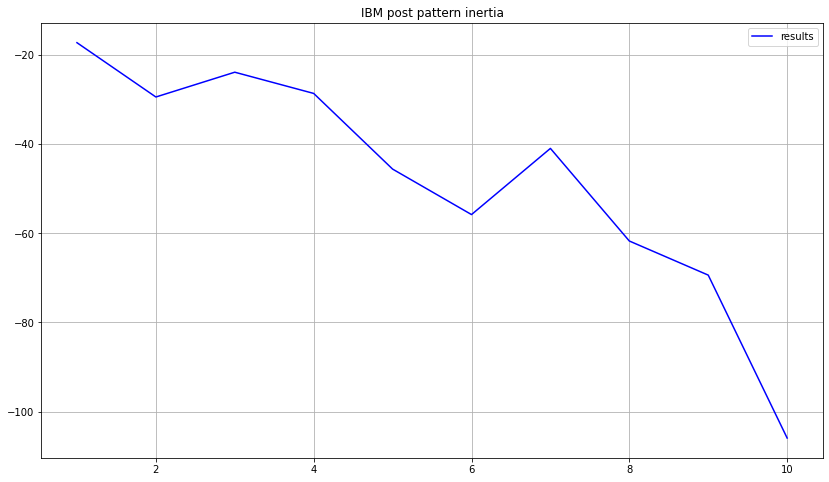


Pattern analysis on: INTC

Occurrences: 24 

DatetimeIndex(['2001-03-19', '2002-02-08', '2002-02-20', '2004-08-11',
               '2004-08-13', '2005-04-12', '2007-03-29', '2008-09-08',
               '2008-11-18', '2010-06-08', '2011-01-07', '2012-05-21',
               '2012-05-23', '2013-04-05', '2013-05-24', '2013-06-25',
               '2013-07-10', '2014-09-26', '2015-02-03', '2015-07-07',
               '2016-01-04', '2017-03-14', '2017-12-01', '2020-12-21'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -4.41 average of -0.18 with 8 winning trades and 16 loosing trades
After: 2 days: -4.77 average of -0.2 with 12 winning trades and 12 loosing trades
After: 3 days: 1.29 average of 0.05 with 15 winning trades and 9 loosing trades
After: 4 days: -0.01 average of -0.0 with 14 winning trades and 10 loosing trades
After: 5 days: 2.95 average of 0.12 with 16 winning trades and 8 loosing trades
After: 6 days: 2.19 average of 0.09 with 13 winning trade

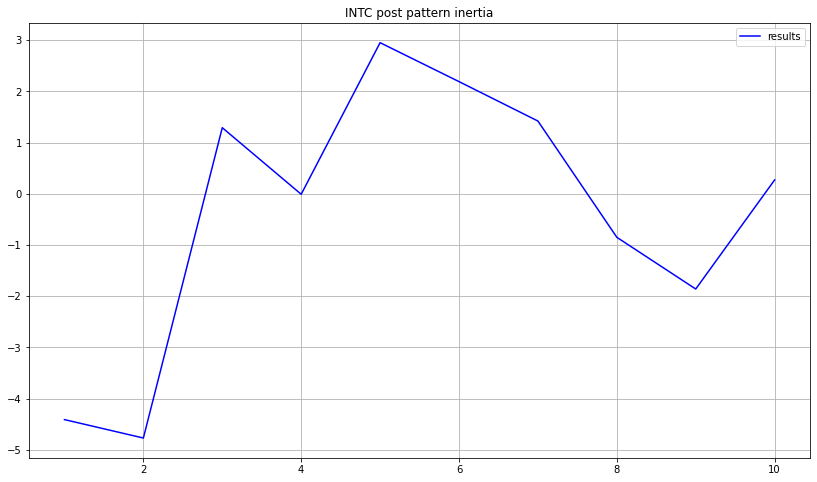


Pattern analysis on: JNJ

Occurrences: 25 

DatetimeIndex(['2000-02-25', '2001-03-15', '2001-11-30', '2002-04-12',
               '2002-07-15', '2003-01-28', '2003-11-06', '2004-12-13',
               '2007-10-22', '2007-10-24', '2009-01-15', '2009-04-23',
               '2009-04-29', '2011-06-23', '2011-08-09', '2012-01-20',
               '2012-04-17', '2015-02-02', '2015-08-12', '2017-07-27',
               '2018-07-02', '2019-05-15', '2019-09-27', '2020-03-24',
               '2020-06-25'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -0.18 average of -0.01 with 13 winning trades and 12 loosing trades
After: 2 days: 13.83 average of 0.55 with 12 winning trades and 13 loosing trades
After: 3 days: 20.97 average of 0.84 with 17 winning trades and 8 loosing trades
After: 4 days: 22.61 average of 0.9 with 17 winning trades and 8 loosing trades
After: 5 days: 28.92 average of 1.16 with 19 winning trades and 6 loosing trades
After: 6 days: 29.17 average

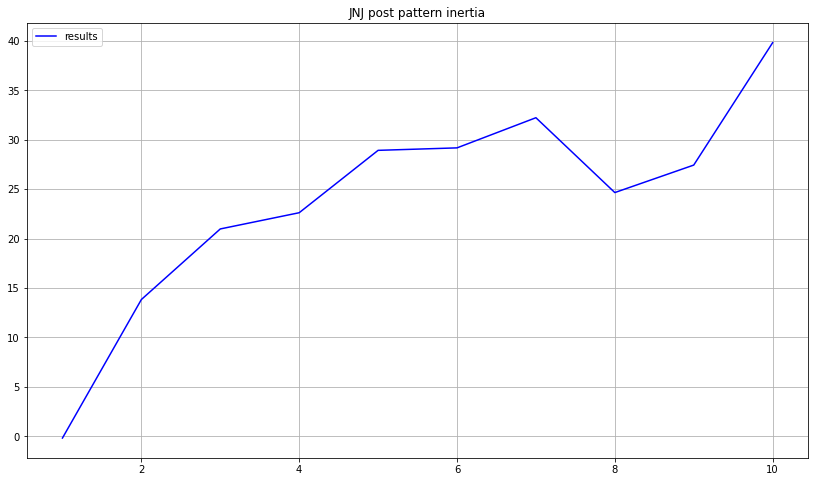


Pattern analysis on: JPM

Occurrences: 22 

DatetimeIndex(['2000-06-20', '2000-09-20', '2001-02-22', '2001-08-09',
               '2001-08-16', '2002-02-22', '2002-06-12', '2002-07-15',
               '2005-01-12', '2007-06-21', '2007-07-30', '2007-11-08',
               '2010-05-14', '2010-05-17', '2011-03-17', '2011-07-18',
               '2015-07-07', '2015-09-29', '2016-06-28', '2018-05-03',
               '2018-06-26', '2020-10-30'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -2.08 average of -0.09 with 9 winning trades and 13 loosing trades
After: 2 days: 8.83 average of 0.4 with 13 winning trades and 9 loosing trades
After: 3 days: 9.98 average of 0.45 with 14 winning trades and 8 loosing trades
After: 4 days: 16.08 average of 0.73 with 11 winning trades and 11 loosing trades
After: 5 days: 12.35 average of 0.56 with 13 winning trades and 9 loosing trades
After: 6 days: 21.02 average of 0.96 with 12 winning trades and 10 loosing trades
After:

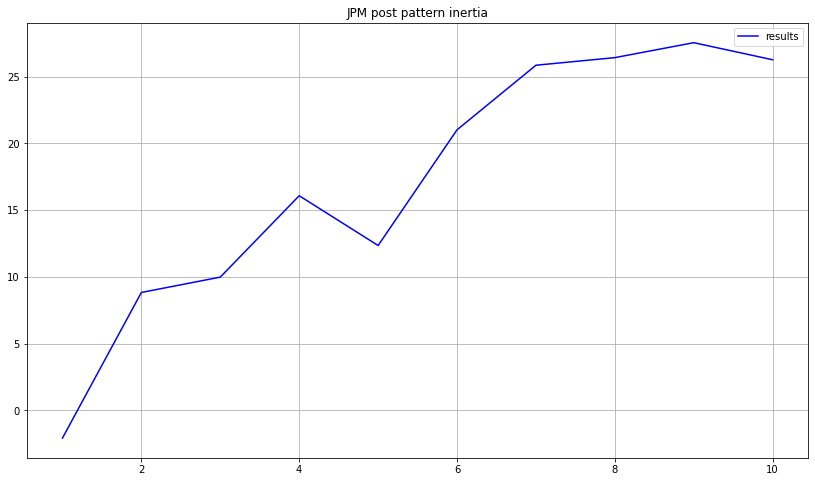


Pattern analysis on: MCD

Occurrences: 23 

DatetimeIndex(['2000-07-25', '2000-08-25', '2001-01-29', '2001-03-15',
               '2002-06-27', '2002-09-05', '2002-11-08', '2002-11-12',
               '2005-03-18', '2006-05-22', '2007-03-06', '2008-01-28',
               '2009-02-12', '2009-04-15', '2010-07-01', '2011-01-07',
               '2013-06-06', '2015-04-02', '2018-02-09', '2019-02-04',
               '2020-03-13', '2020-12-07', '2021-05-19'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -3.43 average of -0.15 with 10 winning trades and 13 loosing trades
After: 2 days: -7.49 average of -0.33 with 10 winning trades and 13 loosing trades
After: 3 days: -19.22 average of -0.84 with 10 winning trades and 13 loosing trades
After: 4 days: -6.41 average of -0.28 with 9 winning trades and 14 loosing trades
After: 5 days: -7.47 average of -0.32 with 11 winning trades and 12 loosing trades
After: 6 days: -10.96 average of -0.48 with 13 winning trades a

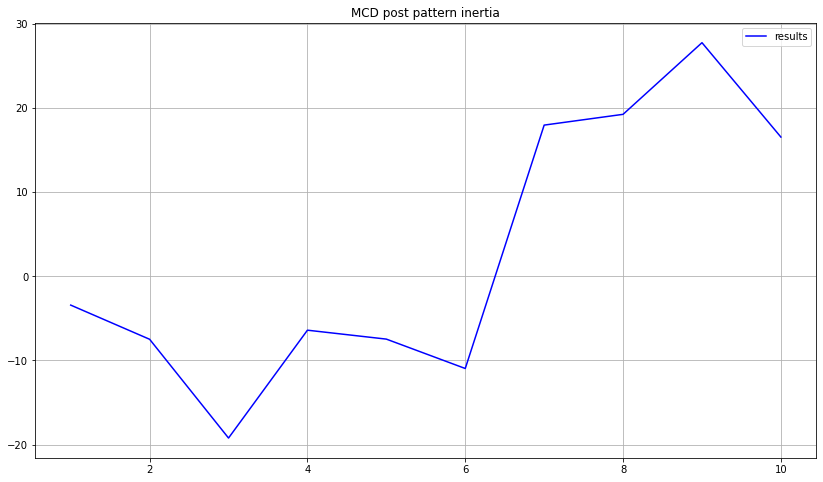


Pattern analysis on: MMM

Occurrences: 26 

DatetimeIndex(['2000-06-08', '2001-01-09', '2002-04-01', '2003-02-13',
               '2003-03-12', '2004-01-30', '2004-02-03', '2007-10-24',
               '2008-01-09', '2008-06-30', '2009-01-21', '2010-05-06',
               '2010-06-08', '2010-08-18', '2010-11-03', '2013-04-29',
               '2014-09-26', '2015-04-28', '2015-07-07', '2016-06-27',
               '2018-01-03', '2018-02-09', '2018-12-10', '2020-03-13',
               '2020-05-14', '2021-01-15'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 10.34 average of 0.4 with 16 winning trades and 10 loosing trades
After: 2 days: 32.87 average of 1.26 with 17 winning trades and 9 loosing trades
After: 3 days: 46.85 average of 1.8 with 17 winning trades and 9 loosing trades
After: 4 days: 55.1 average of 2.12 with 20 winning trades and 6 loosing trades
After: 5 days: 48.25 average of 1.86 with 18 winning trades and 8 loosing trades
After: 6 days: 39.

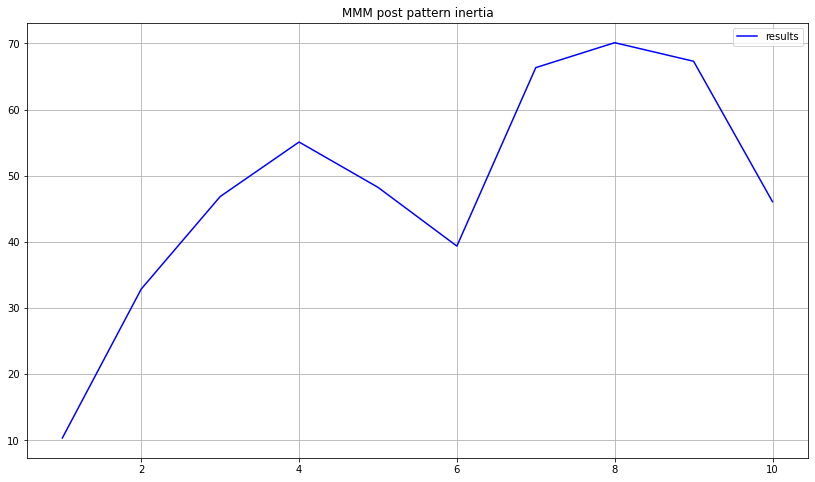


Pattern analysis on: MSFT

Occurrences: 16 

DatetimeIndex(['2001-09-19', '2002-01-02', '2002-01-30', '2002-07-15',
               '2008-11-18', '2009-01-15', '2010-02-01', '2011-02-14',
               '2011-02-16', '2013-08-15', '2013-12-18', '2014-05-07',
               '2015-07-07', '2016-02-08', '2016-10-12', '2018-10-30'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 1.2 average of 0.08 with 10 winning trades and 6 loosing trades
After: 2 days: -1.11 average of -0.07 with 10 winning trades and 6 loosing trades
After: 3 days: 1.25 average of 0.08 with 9 winning trades and 7 loosing trades
After: 4 days: 3.81 average of 0.24 with 9 winning trades and 7 loosing trades
After: 5 days: 1.77 average of 0.11 with 9 winning trades and 7 loosing trades
After: 6 days: 8.12 average of 0.51 with 9 winning trades and 7 loosing trades
After: 7 days: 12.64 average of 0.79 with 9 winning trades and 7 loosing trades
After: 8 days: 7.71 average of 0.48 with 8 winni

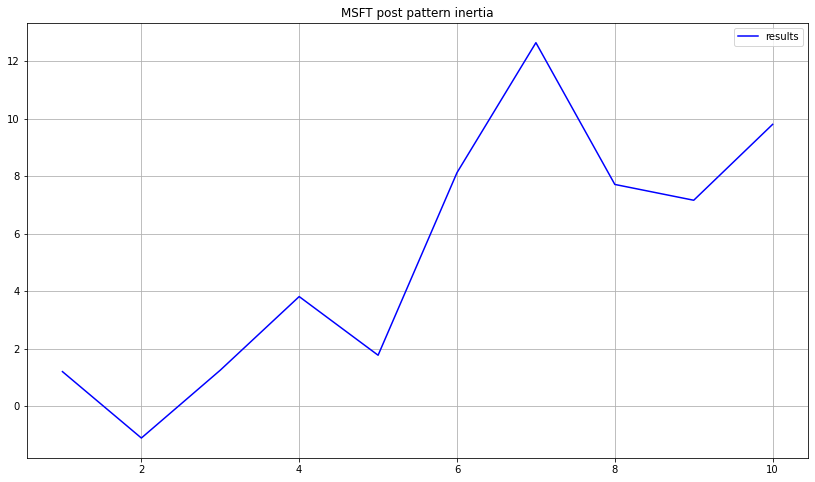


Pattern analysis on: NKE

Occurrences: 21 

DatetimeIndex(['2002-08-15', '2003-07-02', '2004-05-05', '2004-07-28',
               '2006-01-19', '2006-04-04', '2006-08-07', '2006-12-19',
               '2007-11-08', '2008-03-11', '2010-01-20', '2010-05-19',
               '2012-06-04', '2012-06-18', '2013-05-24', '2014-06-13',
               '2015-08-12', '2016-05-06', '2017-05-11', '2019-05-06',
               '2021-03-05'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 0.86 average of 0.04 with 9 winning trades and 12 loosing trades
After: 2 days: 3.57 average of 0.17 with 11 winning trades and 10 loosing trades
After: 3 days: 2.53 average of 0.12 with 9 winning trades and 12 loosing trades
After: 4 days: 6.95 average of 0.33 with 11 winning trades and 10 loosing trades
After: 5 days: 4.4 average of 0.21 with 10 winning trades and 11 loosing trades
After: 6 days: 8.74 average of 0.42 with 9 winning trades and 12 loosing trades
After: 7 days: 4.21 aver

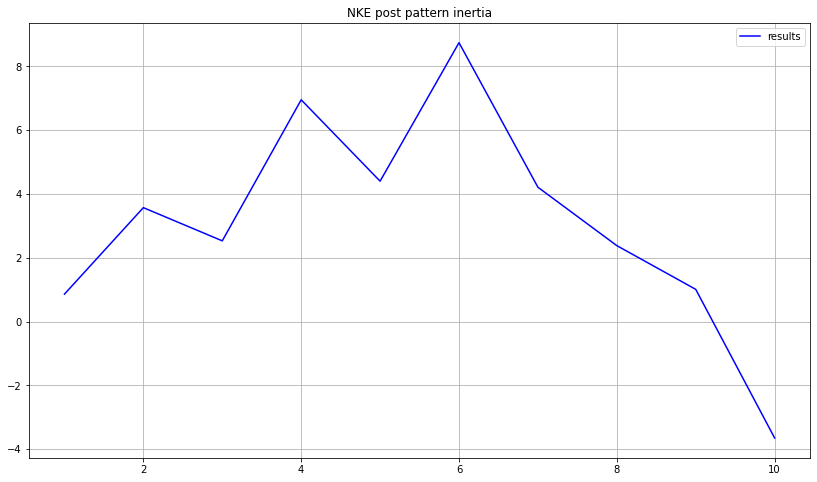


Pattern analysis on: PFE

Occurrences: 35 

DatetimeIndex(['2000-02-18', '2000-02-23', '2000-12-01', '2001-03-22',
               '2001-05-24', '2002-12-03', '2003-02-14', '2003-02-25',
               '2003-04-17', '2004-05-12', '2004-10-07', '2004-10-25',
               '2005-06-09', '2005-10-19', '2006-10-06', '2006-10-20',
               '2006-10-24', '2007-09-17', '2007-10-24', '2007-11-20',
               '2009-01-15', '2009-04-21', '2012-05-24', '2012-06-05',
               '2012-07-11', '2012-12-27', '2014-10-15', '2016-12-07',
               '2017-05-02', '2017-07-28', '2018-02-09', '2018-03-26',
               '2019-08-07', '2020-06-03', '2020-08-28'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 3.08 average of 0.09 with 20 winning trades and 15 loosing trades
After: 2 days: 7.38 average of 0.21 with 22 winning trades and 13 loosing trades
After: 3 days: 6.72 average of 0.19 with 19 winning trades and 16 loosing trades
After: 4 days: 7.1 ave

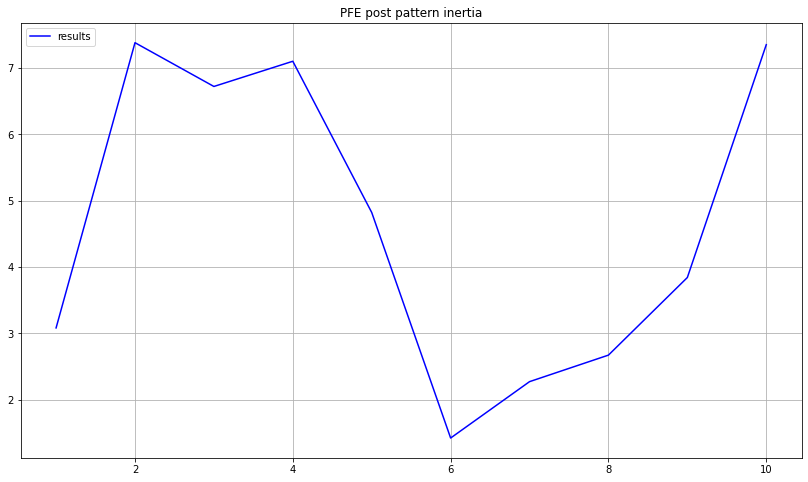


Pattern analysis on: XOM

Occurrences: 25 

DatetimeIndex(['2001-07-09', '2002-02-12', '2002-06-14', '2002-09-04',
               '2002-09-25', '2003-10-29', '2004-08-11', '2011-06-23',
               '2011-08-09', '2012-05-23', '2012-10-15', '2012-12-27',
               '2013-02-06', '2013-08-01', '2014-10-03', '2016-06-27',
               '2016-08-31', '2017-05-26', '2017-07-28', '2018-02-09',
               '2018-07-30', '2019-05-07', '2019-05-24', '2019-07-22',
               '2021-08-16'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -5.66 average of -0.23 with 13 winning trades and 12 loosing trades
After: 2 days: -1.76 average of -0.07 with 11 winning trades and 14 loosing trades
After: 3 days: 2.14 average of 0.09 with 12 winning trades and 13 loosing trades
After: 4 days: -2.76 average of -0.11 with 11 winning trades and 14 loosing trades
After: 5 days: 0.29 average of 0.01 with 10 winning trades and 15 loosing trades
After: 6 days: -0.96 ave

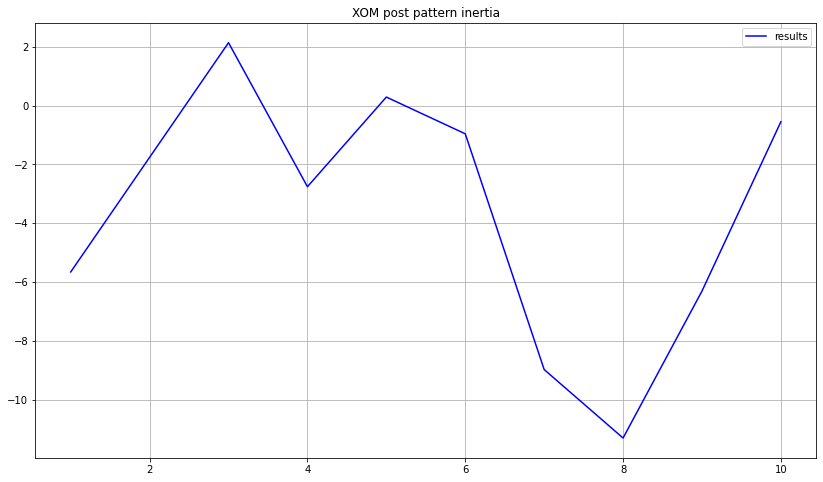


Basket analysis:
Positive inertia after 1 bars: ['CAT', 'CSCO', 'DIS', 'GS', 'HD', 'MMM', 'MSFT', 'NKE', 'PFE']
Positive inertia after 2 bars: ['AXP', 'AAPL', 'CAT', 'GS', 'HD', 'JNJ', 'JPM', 'MMM', 'NKE', 'PFE']
Positive inertia after 3 bars: ['AXP', 'AAPL', 'CAT', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'MMM', 'MSFT', 'NKE', 'PFE', 'XOM']
Positive inertia after 4 bars: ['AXP', 'AAPL', 'CAT', 'GS', 'HD', 'JNJ', 'JPM', 'MMM', 'MSFT', 'NKE', 'PFE']
Positive inertia after 5 bars: ['AXP', 'AAPL', 'CAT', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'MMM', 'MSFT', 'NKE', 'PFE', 'XOM']
Positive inertia after 6 bars: ['AXP', 'AAPL', 'CAT', 'DIS', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'MMM', 'MSFT', 'NKE', 'PFE']
Positive inertia after 7 bars: ['AXP', 'AAPL', 'CAT', 'DIS', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MSFT', 'NKE', 'PFE']
Positive inertia after 8 bars: ['AXP', 'CAT', 'GS', 'HD', 'JNJ', 'JPM', 'MCD', 'MMM', 'MSFT', 'NKE', 'PFE']
Positive inertia after 9 bars: ['AXP', 'AAPL', 'CAT', 'DIS', 'GS',

,AXP,AAPL,BA,CAT,CVX,CSCO,DIS,KO,GS,HD,...,INTC,JNJ,JPM,MCD,MMM,MSFT,NKE,PFE,XOM,basket
1,-1.46,-0.10,-28.99,3.94,-20.89,1.39,1.14,-3.89,22.63,9.05,...,-4.41,-0.18,-2.08,-3.43,10.34,1.20,0.86,3.08,-5.66,-1.7360
2,3.96,0.11,-67.18,12.96,-34.89,-6.55,-13.56,-10.87,47.43,9.23,...,-4.77,13.83,8.83,-7.49,32.87,-1.11,3.57,7.38,-1.76,-1.8725
3,5.10,12.61,-39.99,22.05,-45.52,-11.59,-13.20,-11.64,50.21,14.00,...,1.29,20.97,9.98,-19.22,46.85,1.25,2.53,6.72,2.14,1.5330
4,9.76,9.48,-73.28,21.88,-61.47,-13.08,-1.20,-12.06,90.62,18.93,...,-0.01,22.61,16.08,-6.41,55.10,3.81,6.95,7.10,-2.76,3.1705
5,1.00,9.26,-86.48,17.39,-54.67,-6.04,-7.67,-14.07,99.77,29.51,...,2.95,28.92,12.35,-7.47,48.25,1.77,4.40,4.82,0.29,1.9335
6,14.64,5.37,-125.44,18.29,-84.06,-11.60,9.00,-16.57,105.27,45.57,...,2.19,29.17,21.02,-10.96,39.36,8.12,8.74,1.42,-0.96,0.1380
7,12.93,3.18,-135.08,14.31,-88.27,-7.73,4.09,-21.63,110.00,43.92,...,1.42,32.22,25.86,17.95,66.35,12.64,4.21,2.27,-8.98,2.4345
8,0.48,-1.10,-125.15,25.90,-91.26,-3.89,-7.47,-23.70,112.82,45.54,...,-0.85,24.65,26.43,19.23,70.12,7.71,2.38,2.67,-11.31,0.5730
9,0.05,2.30,-120.71,32.88,-95.76,-4.93,4.88,-23.83,94.89,54.57,...,-1.86,27.43,27.55,27.74,67.31,7.16,1.01,3.84,-6.31,1.4410
10,-10.95,4.95,-82.32,15.93,-89.34,1.98,-4.05,-23.89,91.56,65.68,...,0.27,39.81,26.27,16.53,46.07,9.80,-3.65,7.35,-0.55,0.2760


In [40]:
basket_results = pd.DataFrame(index = range(1,days_after + 1))

for ticker in tickerlist:

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    pattern = (dataset.low < dataset.BBL) & (dataset.close > dataset.BBL) & \
              (dataset.close_pos > 70) & (dataset.open_pos > 70) & (dataset.range_perc > 1)
    
    results = pattern_stats(dataset, pattern, "long", days_after, ticker)
    
    if show_patterns == True:
        plot_patterns(dataset,results[0])
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

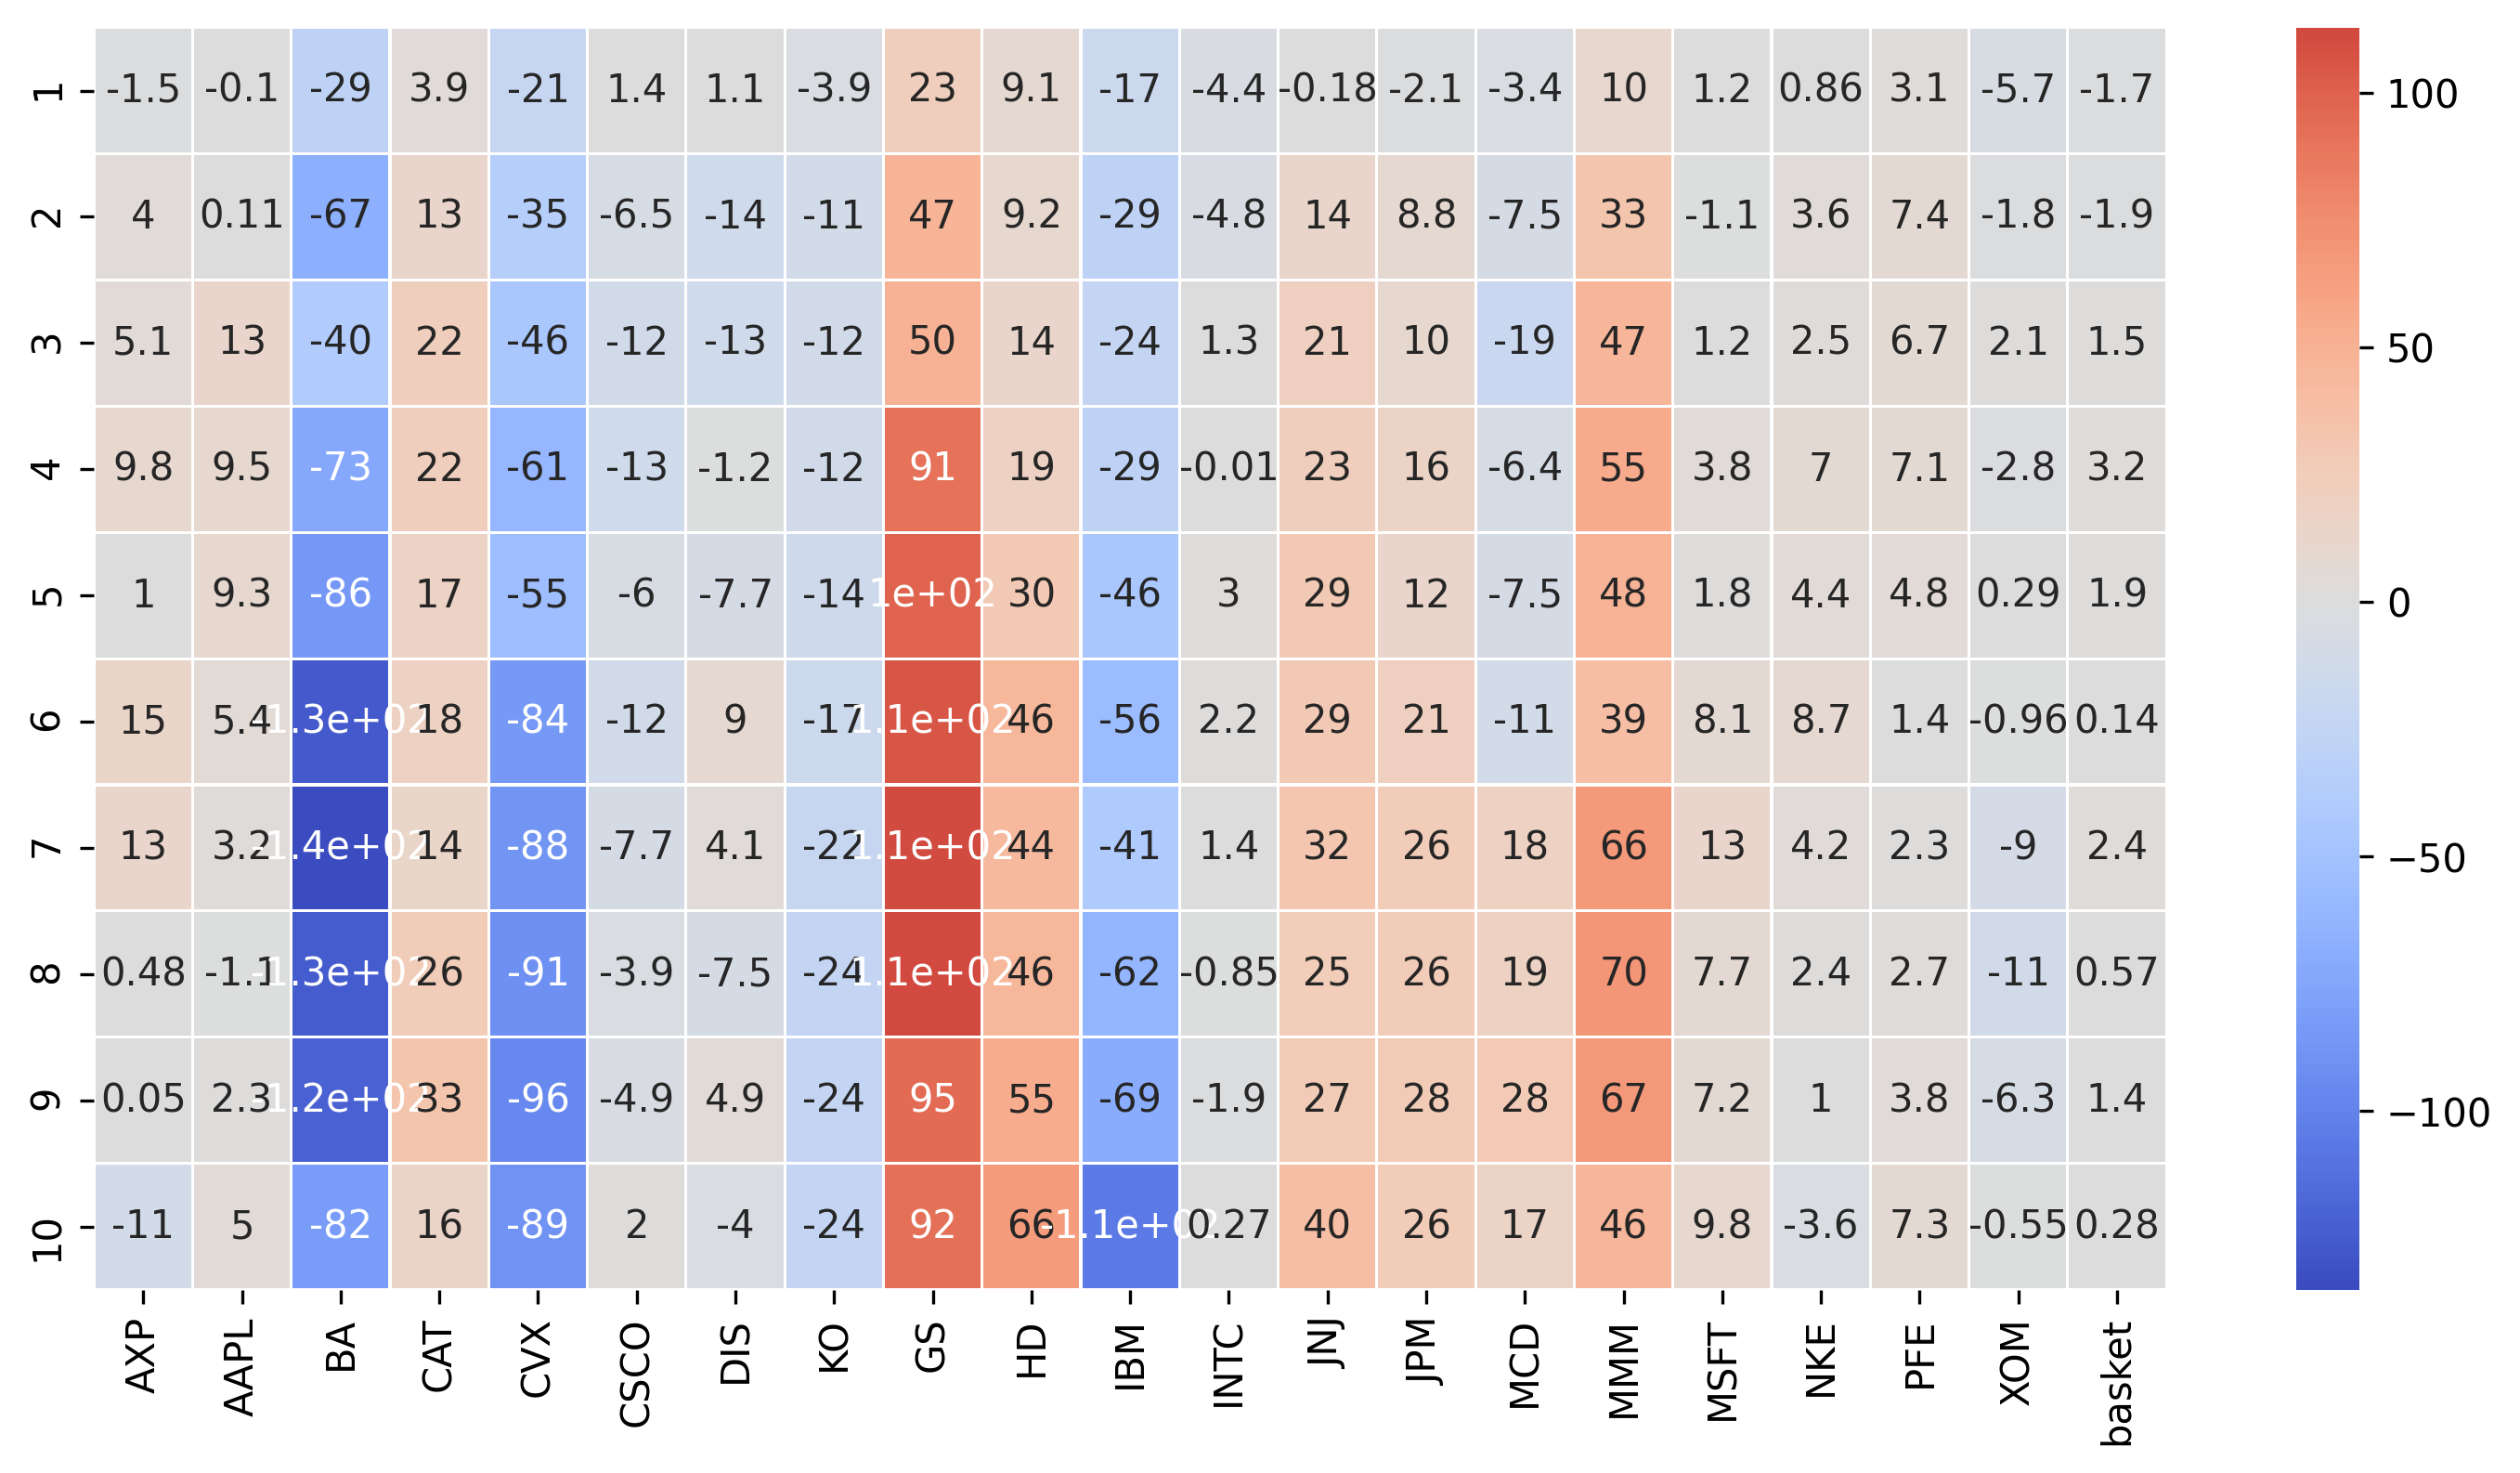

In [41]:
import seaborn as sns
plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [42]:
basket_results.iplot(title = "Pattern inertia")

# <span style="color:red">Esempio "Shooting Star"</span>

Pattern analysis on: AXP

Occurrences: 14 

DatetimeIndex(['2000-09-06', '2002-04-23', '2008-05-05', '2010-03-25',
               '2010-04-23', '2011-10-25', '2012-12-11', '2013-05-28',
               '2013-07-08', '2014-12-11', '2019-06-11', '2019-07-10',
               '2020-09-03', '2021-07-07'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 1.92 average of 0.14 with 7 winning trades and 7 loosing trades
After: 2 days: 1.54 average of 0.11 with 8 winning trades and 6 loosing trades
After: 3 days: 0.62 average of 0.04 with 10 winning trades and 4 loosing trades
After: 4 days: -0.11 average of -0.01 with 7 winning trades and 7 loosing trades
After: 5 days: -2.27 average of -0.16 with 4 winning trades and 10 loosing trades
After: 6 days: -9.54 average of -0.68 with 4 winning trades and 10 loosing trades
After: 7 days: -4.18 average of -0.3 with 6 winning trades and 8 loosing trades
After: 8 days: 7.08 average of 0.51 with 8 winning trades and 6 loosing 

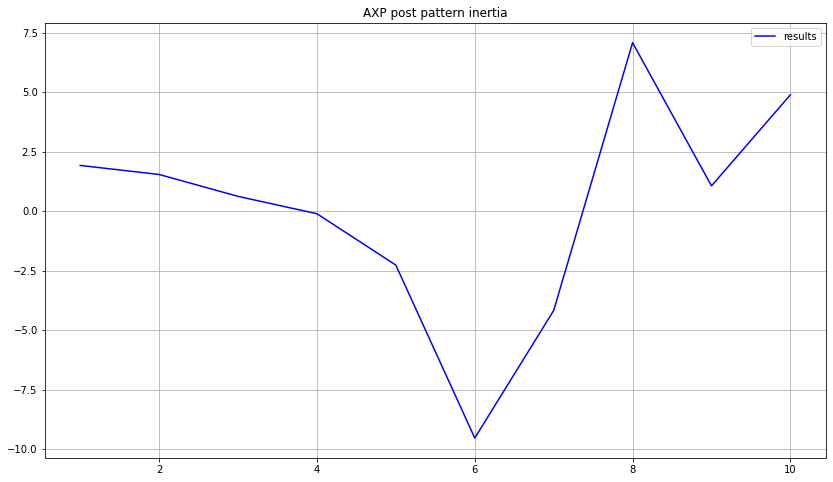


Pattern analysis on: AAPL

Occurrences: 35 

DatetimeIndex(['2000-03-23', '2001-06-29', '2001-10-16', '2001-11-07',
               '2002-02-05', '2003-02-05', '2003-07-09', '2003-09-03',
               '2003-09-04', '2003-10-10', '2003-10-15', '2004-01-02',
               '2004-01-09', '2004-02-12', '2004-06-03', '2004-06-09',
               '2004-08-30', '2005-04-08', '2006-05-04', '2007-02-23',
               '2007-04-30', '2007-12-27', '2008-04-07', '2009-03-24',
               '2009-08-25', '2009-09-23', '2015-10-21', '2016-02-29',
               '2018-05-07', '2019-04-09', '2019-06-10', '2019-10-01',
               '2019-12-18', '2021-06-08', '2021-09-01'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -0.08 average of -0.0 with 20 winning trades and 15 loosing trades
After: 2 days: -0.68 average of -0.02 with 18 winning trades and 17 loosing trades
After: 3 days: -4.09 average of -0.12 with 14 winning trades and 20 loosing trades
After: 4 days: -

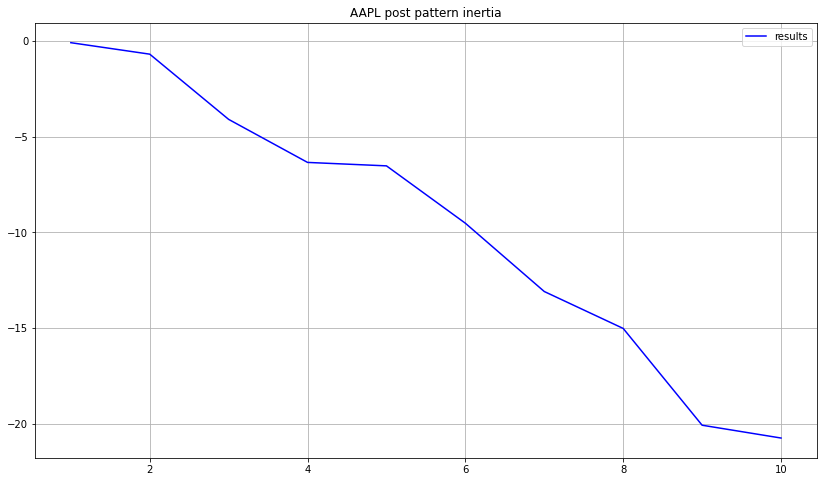


Pattern analysis on: BA

Occurrences: 23 

DatetimeIndex(['2000-06-28', '2001-04-18', '2001-04-30', '2001-07-27',
               '2002-02-28', '2003-01-06', '2004-01-09', '2004-11-03',
               '2005-04-05', '2005-05-10', '2005-08-24', '2006-09-28',
               '2012-01-23', '2012-10-11', '2015-09-17', '2016-07-27',
               '2017-02-28', '2017-06-20', '2017-07-12', '2017-09-22',
               '2018-02-27', '2018-05-10', '2021-06-02'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 13.86 average of 0.6 with 15 winning trades and 8 loosing trades
After: 2 days: 15.79 average of 0.69 with 10 winning trades and 13 loosing trades
After: 3 days: 16.51 average of 0.72 with 10 winning trades and 13 loosing trades
After: 4 days: 12.17 average of 0.53 with 12 winning trades and 11 loosing trades
After: 5 days: 15.63 average of 0.68 with 11 winning trades and 12 loosing trades
After: 6 days: 6.75 average of 0.29 with 11 winning trades and 12 loosi

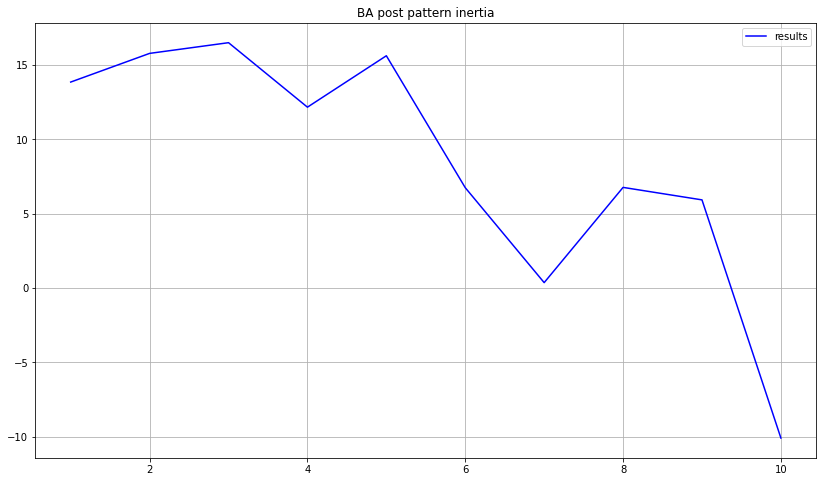


Pattern analysis on: CAT

Occurrences: 28 

DatetimeIndex(['2000-11-30', '2001-04-30', '2001-11-08', '2003-03-14',
               '2003-06-06', '2004-11-02', '2006-09-06', '2007-05-15',
               '2007-05-23', '2008-05-19', '2008-05-21', '2009-04-14',
               '2009-04-22', '2010-12-07', '2011-03-25', '2011-03-28',
               '2011-07-07', '2012-08-07', '2012-12-19', '2013-08-13',
               '2014-01-16', '2016-10-03', '2017-07-12', '2017-08-25',
               '2017-10-26', '2018-04-17', '2018-05-21', '2020-04-07'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -0.84 average of -0.03 with 17 winning trades and 11 loosing trades
After: 2 days: -0.42 average of -0.02 with 14 winning trades and 14 loosing trades
After: 3 days: 14.98 average of 0.54 with 17 winning trades and 11 loosing trades
After: 4 days: 13.45 average of 0.48 with 15 winning trades and 13 loosing trades
After: 5 days: 25.04 average of 0.89 with 16 winning trades and

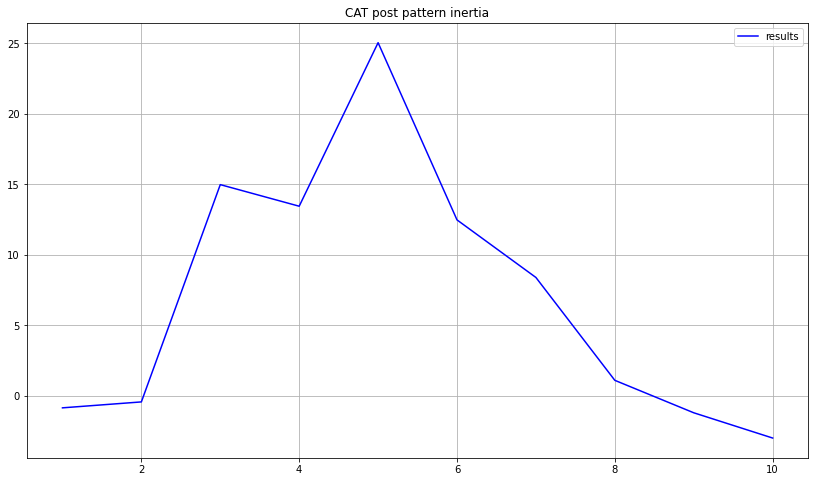


Pattern analysis on: CVX

Occurrences: 20 

DatetimeIndex(['2000-03-13', '2000-06-16', '2001-12-26', '2003-12-02',
               '2003-12-03', '2004-01-27', '2004-07-15', '2004-10-07',
               '2006-04-26', '2006-06-27', '2006-08-09', '2008-05-21',
               '2012-03-14', '2012-07-31', '2012-12-12', '2014-03-21',
               '2016-12-05', '2017-09-14', '2018-05-09', '2018-12-03'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 2.53 average of 0.13 with 10 winning trades and 10 loosing trades
After: 2 days: -1.78 average of -0.09 with 9 winning trades and 11 loosing trades
After: 3 days: -5.06 average of -0.25 with 7 winning trades and 13 loosing trades
After: 4 days: -4.78 average of -0.24 with 8 winning trades and 12 loosing trades
After: 5 days: -3.91 average of -0.2 with 9 winning trades and 11 loosing trades
After: 6 days: -5.41 average of -0.27 with 10 winning trades and 10 loosing trades
After: 7 days: -4.85 average of -0.24 with 9

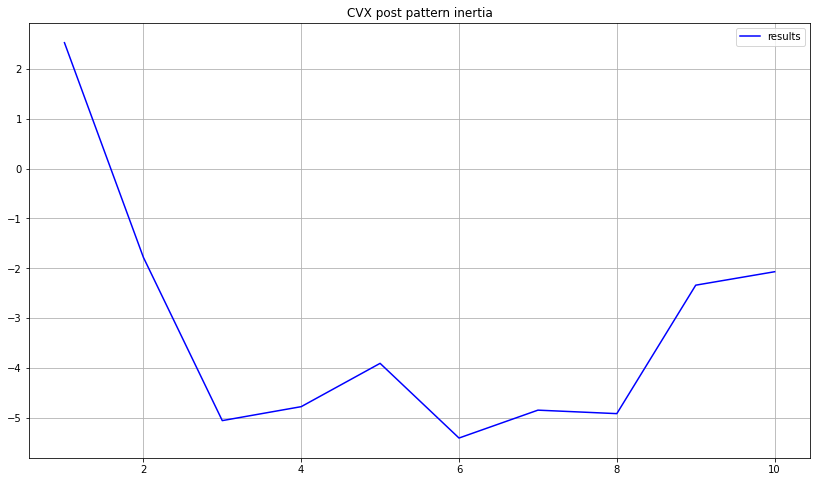


Pattern analysis on: CSCO

Occurrences: 23 

DatetimeIndex(['2003-01-08', '2003-06-09', '2003-07-09', '2003-07-31',
               '2003-12-03', '2006-09-13', '2007-10-01', '2008-03-12',
               '2011-02-07', '2011-09-14', '2014-04-03', '2014-12-23',
               '2014-12-24', '2015-07-24', '2015-08-13', '2016-11-14',
               '2016-11-16', '2016-12-14', '2018-01-04', '2018-01-24',
               '2018-09-27', '2019-12-16', '2021-01-13'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -0.93 average of -0.04 with 7 winning trades and 16 loosing trades
After: 2 days: -2.2 average of -0.1 with 6 winning trades and 17 loosing trades
After: 3 days: 1.42 average of 0.06 with 8 winning trades and 15 loosing trades
After: 4 days: 4.11 average of 0.18 with 13 winning trades and 10 loosing trades
After: 5 days: 8.08 average of 0.35 with 14 winning trades and 9 loosing trades
After: 6 days: 10.17 average of 0.44 with 14 winning trades and 9 loosing 

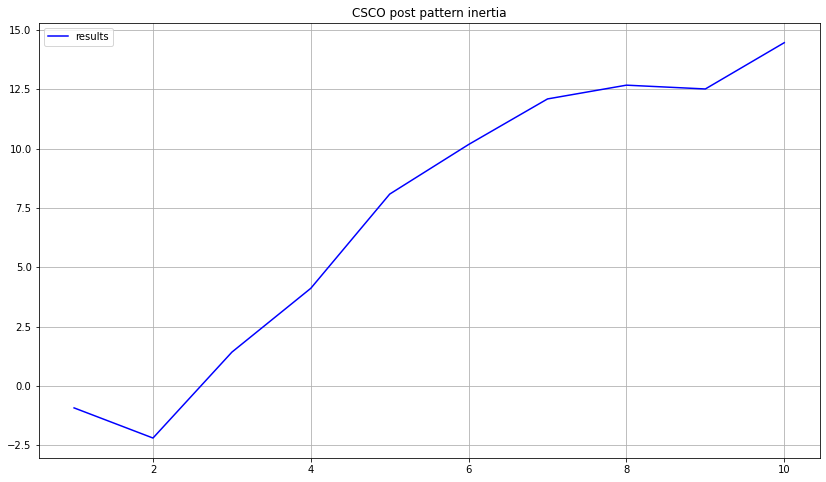


Pattern analysis on: DIS

Occurrences: 18 

DatetimeIndex(['2001-11-05', '2001-11-08', '2003-10-03', '2004-12-02',
               '2005-01-03', '2006-07-06', '2006-09-27', '2008-08-15',
               '2009-08-25', '2009-10-21', '2014-08-06', '2016-03-31',
               '2017-04-13', '2018-07-17', '2019-07-11', '2020-05-26',
               '2020-08-11', '2020-09-10'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 2.65 average of 0.15 with 9 winning trades and 9 loosing trades
After: 2 days: 6.94 average of 0.39 with 10 winning trades and 8 loosing trades
After: 3 days: 9.63 average of 0.54 with 9 winning trades and 9 loosing trades
After: 4 days: 9.9 average of 0.55 with 10 winning trades and 8 loosing trades
After: 5 days: 15.74 average of 0.87 with 10 winning trades and 8 loosing trades
After: 6 days: 15.5 average of 0.86 with 10 winning trades and 8 loosing trades
After: 7 days: 9.76 average of 0.54 with 9 winning trades and 9 loosing trades
After:

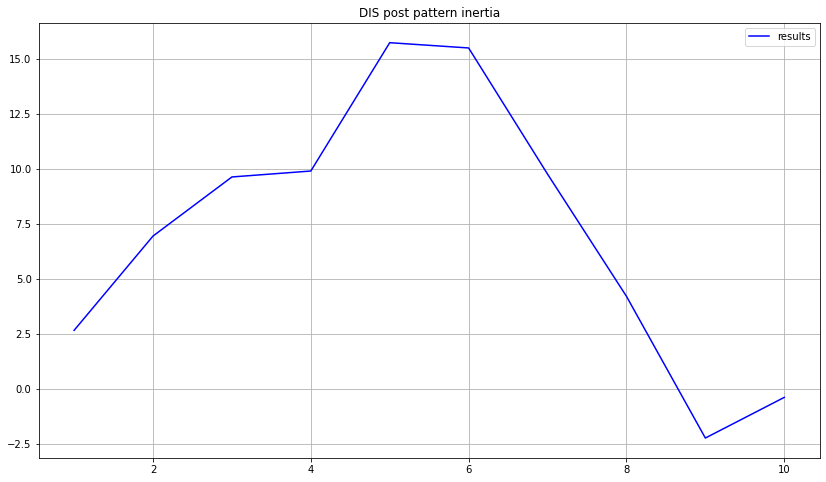


Pattern analysis on: KO

Occurrences: 17 

DatetimeIndex(['2001-04-24', '2002-02-07', '2002-07-01', '2007-01-18',
               '2008-01-08', '2008-03-27', '2011-05-13', '2013-11-25',
               '2014-04-10', '2014-04-11', '2015-05-11', '2015-10-06',
               '2019-06-12', '2020-07-15', '2020-07-28', '2021-04-22',
               '2021-05-10'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 0.52 average of 0.03 with 11 winning trades and 6 loosing trades
After: 2 days: -0.77 average of -0.05 with 11 winning trades and 6 loosing trades
After: 3 days: -1.47 average of -0.09 with 10 winning trades and 7 loosing trades
After: 4 days: -2.03 average of -0.12 with 8 winning trades and 9 loosing trades
After: 5 days: -4.78 average of -0.28 with 8 winning trades and 9 loosing trades
After: 6 days: -3.1 average of -0.18 with 9 winning trades and 8 loosing trades
After: 7 days: -1.66 average of -0.1 with 9 winning trades and 8 loosing trades
After: 8 day

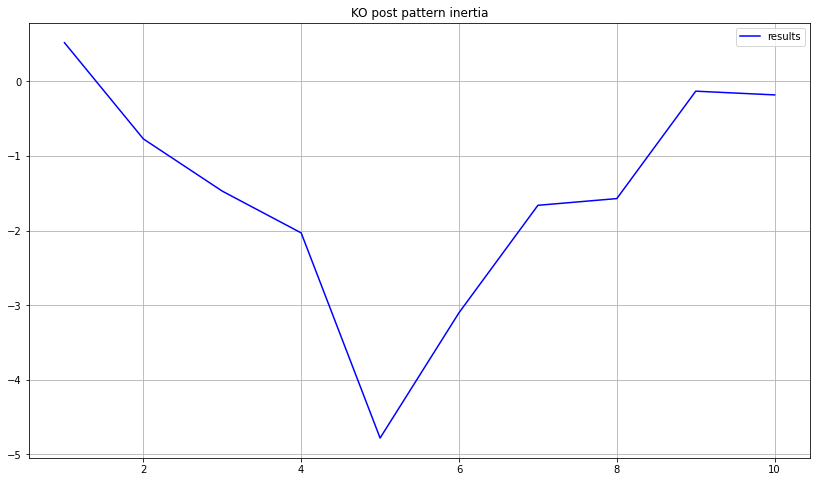


Pattern analysis on: GS

Occurrences: 26 

DatetimeIndex(['2000-02-25', '2000-09-06', '2001-08-02', '2002-08-13',
               '2002-11-22', '2004-02-17', '2004-11-02', '2005-02-09',
               '2005-07-12', '2005-08-08', '2006-01-11', '2006-03-28',
               '2006-08-17', '2007-09-24', '2007-10-30', '2009-03-24',
               '2010-02-23', '2011-04-07', '2011-10-19', '2013-05-16',
               '2017-08-08', '2019-12-16', '2020-01-07', '2020-07-16',
               '2021-03-03', '2021-08-02'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -15.94 average of -0.61 with 9 winning trades and 17 loosing trades
After: 2 days: -4.12 average of -0.16 with 13 winning trades and 13 loosing trades
After: 3 days: -20.61 average of -0.79 with 10 winning trades and 16 loosing trades
After: 4 days: -5.28 average of -0.2 with 13 winning trades and 13 loosing trades
After: 5 days: -38.93 average of -1.5 with 10 winning trades and 16 loosing trades
After: 

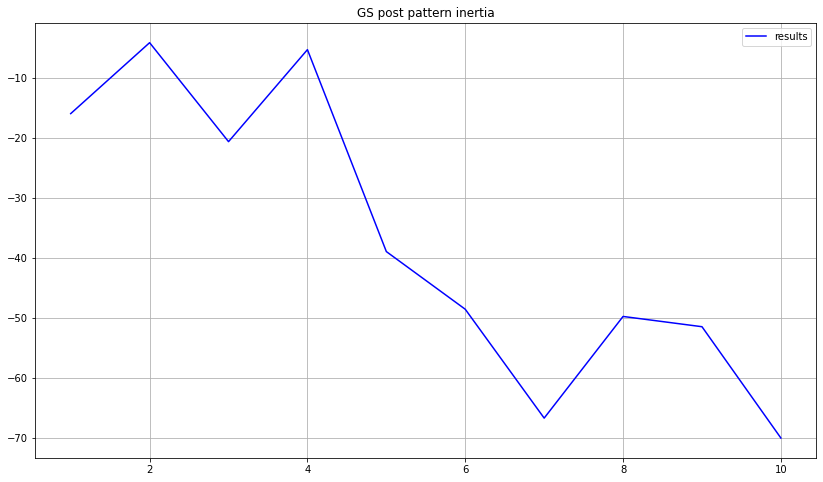


Pattern analysis on: HD

Occurrences: 25 

DatetimeIndex(['2001-04-23', '2003-04-29', '2003-05-20', '2003-06-17',
               '2003-10-29', '2004-01-27', '2004-05-28', '2004-11-01',
               '2005-07-14', '2005-11-14', '2005-11-25', '2010-04-26',
               '2010-11-16', '2011-05-17', '2011-07-21', '2011-11-16',
               '2012-02-15', '2012-09-25', '2013-04-11', '2014-12-12',
               '2014-12-31', '2015-03-24', '2017-03-24', '2019-03-22',
               '2020-01-22'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 6.8 average of 0.27 with 15 winning trades and 10 loosing trades
After: 2 days: 12.33 average of 0.49 with 16 winning trades and 9 loosing trades
After: 3 days: 7.26 average of 0.29 with 16 winning trades and 9 loosing trades
After: 4 days: -2.63 average of -0.11 with 14 winning trades and 11 loosing trades
After: 5 days: -5.8 average of -0.23 with 13 winning trades and 12 loosing trades
After: 6 days: -12.52 average 

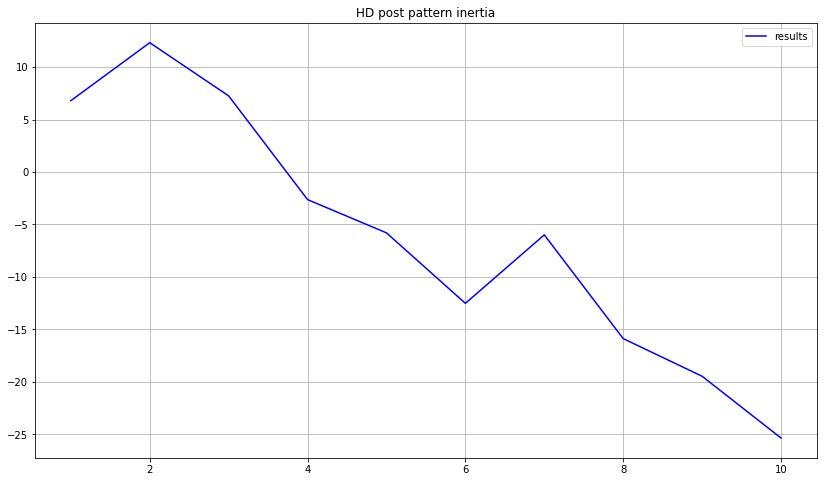


Pattern analysis on: IBM

Occurrences: 28 

DatetimeIndex(['2000-08-31', '2001-01-04', '2001-02-15', '2002-01-09',
               '2003-12-02', '2004-12-02', '2005-10-10', '2005-11-14',
               '2006-03-09', '2006-03-21', '2007-10-02', '2010-03-24',
               '2010-03-25', '2010-04-16', '2011-04-29', '2011-09-28',
               '2011-10-12', '2011-12-05', '2013-05-31', '2013-12-20',
               '2014-02-19', '2014-04-10', '2014-07-17', '2016-12-15',
               '2018-03-16', '2018-06-07', '2018-09-12', '2019-07-01'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -10.73 average of -0.38 with 7 winning trades and 21 loosing trades
After: 2 days: 1.68 average of 0.06 with 16 winning trades and 12 loosing trades
After: 3 days: 17.4 average of 0.62 with 17 winning trades and 11 loosing trades
After: 4 days: 20.28 average of 0.72 with 13 winning trades and 15 loosing trades
After: 5 days: 37.27 average of 1.33 with 17 winning trades and 11

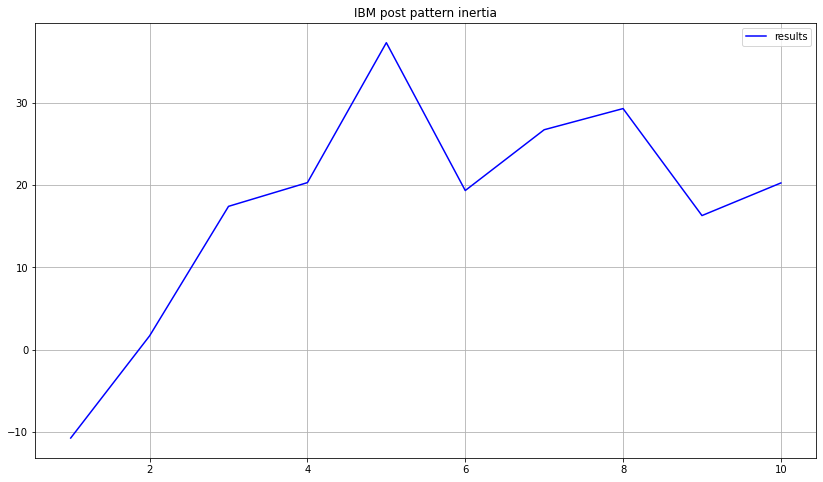


Pattern analysis on: INTC

Occurrences: 23 

DatetimeIndex(['2000-06-06', '2000-08-18', '2000-08-22', '2004-01-09',
               '2004-05-28', '2005-03-08', '2005-03-09', '2005-04-26',
               '2007-06-19', '2008-05-14', '2010-10-11', '2012-03-14',
               '2012-04-17', '2013-05-30', '2013-05-31', '2014-03-27',
               '2016-06-22', '2017-04-03', '2018-04-18', '2019-02-06',
               '2019-10-11', '2019-12-23', '2020-05-19'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -5.94 average of -0.26 with 10 winning trades and 13 loosing trades
After: 2 days: -1.04 average of -0.05 with 10 winning trades and 13 loosing trades
After: 3 days: 0.7 average of 0.03 with 12 winning trades and 11 loosing trades
After: 4 days: 1.83 average of 0.08 with 13 winning trades and 10 loosing trades
After: 5 days: -1.74 average of -0.08 with 12 winning trades and 11 loosing trades
After: 6 days: -3.51 average of -0.15 with 8 winning trades and 15 

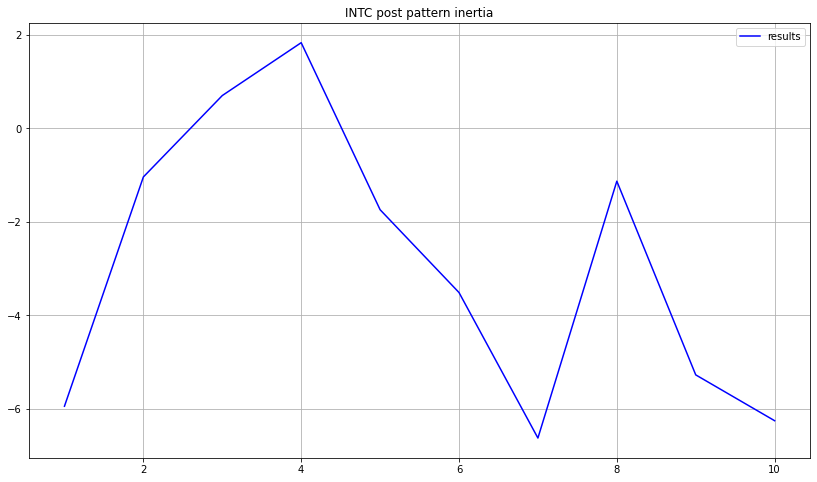


Pattern analysis on: JNJ

Occurrences: 18 

DatetimeIndex(['2000-11-30', '2001-05-01', '2001-06-20', '2002-05-01',
               '2003-11-18', '2004-11-05', '2006-06-07', '2007-01-03',
               '2008-07-09', '2010-11-15', '2012-02-23', '2013-05-22',
               '2013-10-15', '2017-05-17', '2018-12-04', '2019-04-16',
               '2020-02-04', '2020-07-21'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -7.0 average of -0.39 with 5 winning trades and 13 loosing trades
After: 2 days: -1.95 average of -0.11 with 9 winning trades and 9 loosing trades
After: 3 days: 0.76 average of 0.04 with 5 winning trades and 13 loosing trades
After: 4 days: 2.55 average of 0.14 with 7 winning trades and 11 loosing trades
After: 5 days: 1.18 average of 0.07 with 7 winning trades and 11 loosing trades
After: 6 days: 2.65 average of 0.15 with 9 winning trades and 9 loosing trades
After: 7 days: 19.79 average of 1.1 with 9 winning trades and 9 loosing trades
Aft

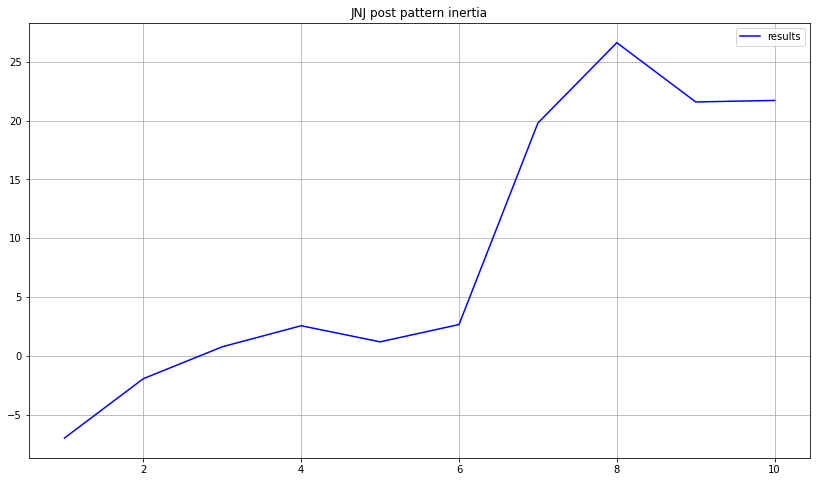


Pattern analysis on: JPM

Occurrences: 21 

DatetimeIndex(['2000-03-24', '2000-08-24', '2000-11-02', '2001-11-08',
               '2002-03-05', '2004-01-02', '2004-03-08', '2004-06-25',
               '2006-04-03', '2010-03-25', '2010-03-26', '2013-03-05',
               '2013-05-16', '2014-01-16', '2014-09-22', '2014-09-23',
               '2015-05-05', '2017-08-08', '2019-02-25', '2021-03-18',
               '2021-05-10'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 4.16 average of 0.2 with 12 winning trades and 9 loosing trades
After: 2 days: 8.66 average of 0.41 with 12 winning trades and 9 loosing trades
After: 3 days: 10.81 average of 0.51 with 12 winning trades and 9 loosing trades
After: 4 days: 6.22 average of 0.3 with 11 winning trades and 10 loosing trades
After: 5 days: 2.65 average of 0.13 with 10 winning trades and 11 loosing trades
After: 6 days: 1.63 average of 0.08 with 10 winning trades and 11 loosing trades
After: 7 days: 8.04 aver

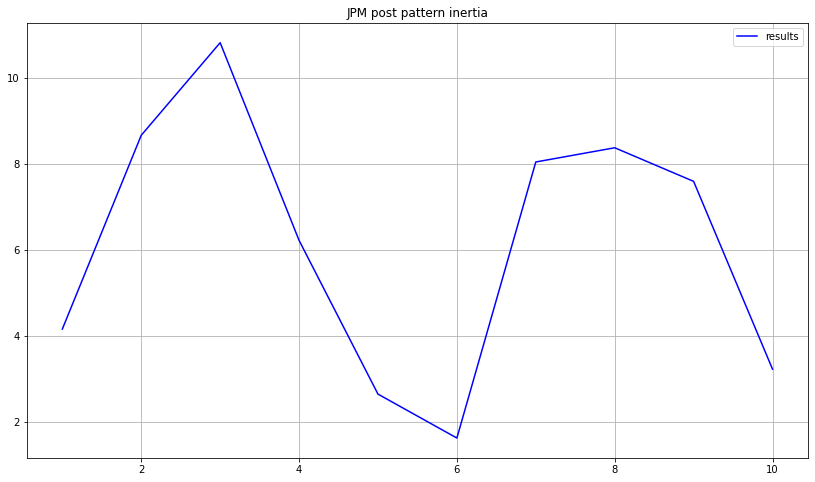


Pattern analysis on: MCD

Occurrences: 27 

DatetimeIndex(['2000-08-07', '2001-07-23', '2001-07-31', '2001-08-21',
               '2002-04-22', '2003-06-02', '2003-10-08', '2004-03-04',
               '2004-06-24', '2005-07-14', '2006-06-30', '2008-09-09',
               '2009-09-28', '2009-09-29', '2010-01-22', '2010-09-09',
               '2010-10-20', '2011-07-25', '2011-10-25', '2011-12-08',
               '2014-02-19', '2017-02-16', '2017-03-17', '2020-08-11',
               '2021-01-21', '2021-07-14', '2021-07-21'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -7.31 average of -0.27 with 10 winning trades and 17 loosing trades
After: 2 days: -11.99 average of -0.44 with 11 winning trades and 16 loosing trades
After: 3 days: -7.06 average of -0.26 with 10 winning trades and 17 loosing trades
After: 4 days: -6.97 average of -0.26 with 13 winning trades and 14 loosing trades
After: 5 days: -4.34 average of -0.16 with 14 winning trades and 13 loosin

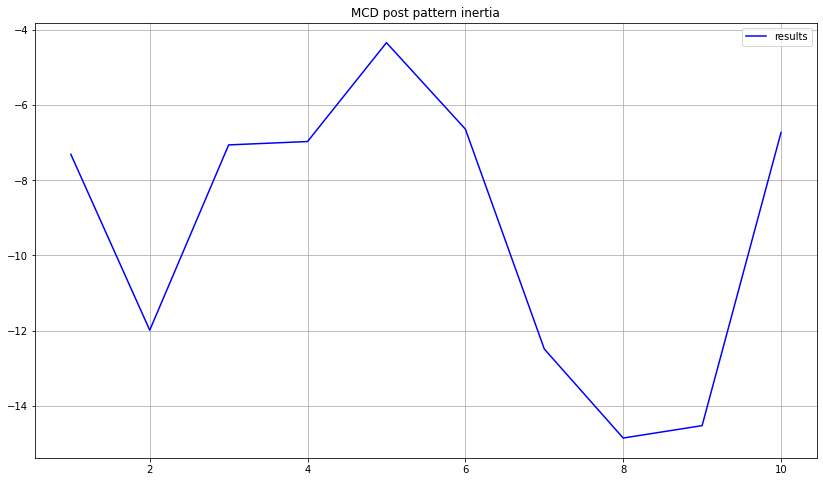


Pattern analysis on: MMM

Occurrences: 22 

DatetimeIndex(['2000-03-03', '2000-06-27', '2000-07-26', '2001-02-07',
               '2001-04-24', '2003-10-10', '2003-12-03', '2005-06-17',
               '2006-03-29', '2006-11-16', '2007-01-18', '2007-05-24',
               '2007-09-20', '2007-09-24', '2008-11-05', '2009-11-11',
               '2010-04-30', '2011-01-27', '2013-06-17', '2013-12-20',
               '2014-04-03', '2018-09-10'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 5.74 average of 0.26 with 14 winning trades and 8 loosing trades
After: 2 days: 15.66 average of 0.71 with 15 winning trades and 7 loosing trades
After: 3 days: 11.87 average of 0.54 with 12 winning trades and 10 loosing trades
After: 4 days: 13.71 average of 0.62 with 12 winning trades and 10 loosing trades
After: 5 days: 19.54 average of 0.89 with 13 winning trades and 9 loosing trades
After: 6 days: 6.67 average of 0.3 with 10 winning trades and 12 loosing trades
After:

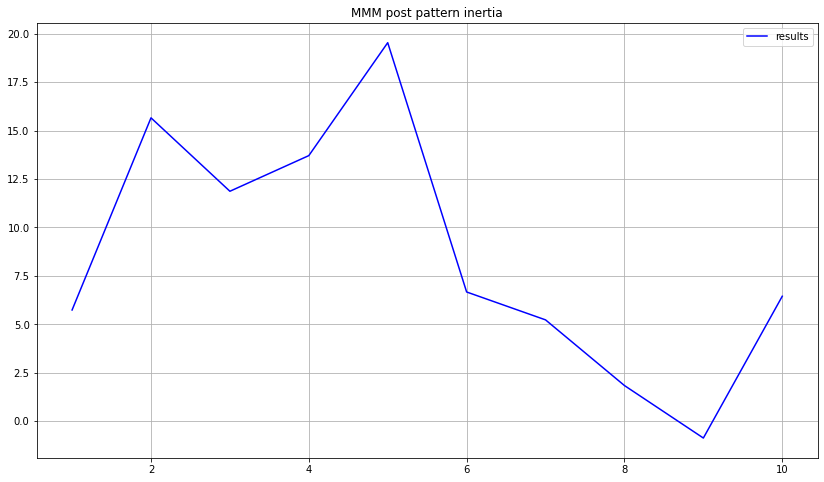


Pattern analysis on: MSFT

Occurrences: 22 

DatetimeIndex(['2001-10-26', '2002-06-17', '2002-10-16', '2003-06-19',
               '2003-12-05', '2006-10-13', '2007-10-09', '2009-04-29',
               '2009-06-16', '2009-12-16', '2010-03-25', '2011-04-05',
               '2013-04-19', '2014-02-21', '2015-12-02', '2016-03-30',
               '2017-09-18', '2020-01-21', '2020-05-05', '2020-06-23',
               '2021-01-22', '2021-03-23'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 9.35 average of 0.42 with 11 winning trades and 11 loosing trades
After: 2 days: 4.08 average of 0.19 with 12 winning trades and 10 loosing trades
After: 3 days: 3.4 average of 0.15 with 10 winning trades and 12 loosing trades
After: 4 days: -0.94 average of -0.04 with 14 winning trades and 8 loosing trades
After: 5 days: 4.57 average of 0.21 with 12 winning trades and 10 loosing trades
After: 6 days: -7.96 average of -0.36 with 13 winning trades and 9 loosing trades
Afte

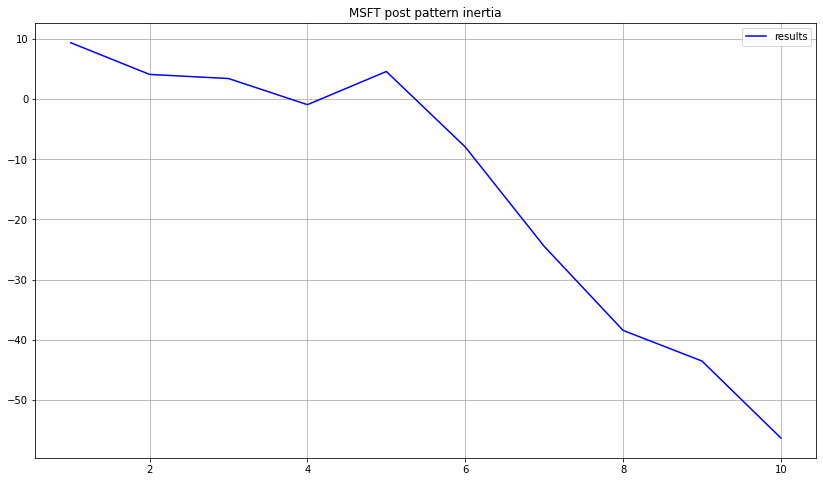


Pattern analysis on: NKE

Occurrences: 24 

DatetimeIndex(['2000-12-06', '2001-06-27', '2001-08-31', '2001-09-04',
               '2001-10-23', '2002-01-04', '2003-03-11', '2003-04-29',
               '2003-06-26', '2004-11-02', '2005-10-04', '2006-02-28',
               '2006-06-12', '2006-06-16', '2007-12-20', '2010-12-01',
               '2011-09-27', '2012-03-20', '2013-02-08', '2015-08-05',
               '2018-05-22', '2018-06-07', '2019-07-09', '2020-05-19'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: 3.69 average of 0.15 with 17 winning trades and 7 loosing trades
After: 2 days: 0.81 average of 0.03 with 17 winning trades and 7 loosing trades
After: 3 days: 1.56 average of 0.06 with 15 winning trades and 9 loosing trades
After: 4 days: 1.06 average of 0.04 with 17 winning trades and 7 loosing trades
After: 5 days: -1.88 average of -0.08 with 15 winning trades and 9 loosing trades
After: 6 days: -0.08 average of -0.0 with 15 winning trades an

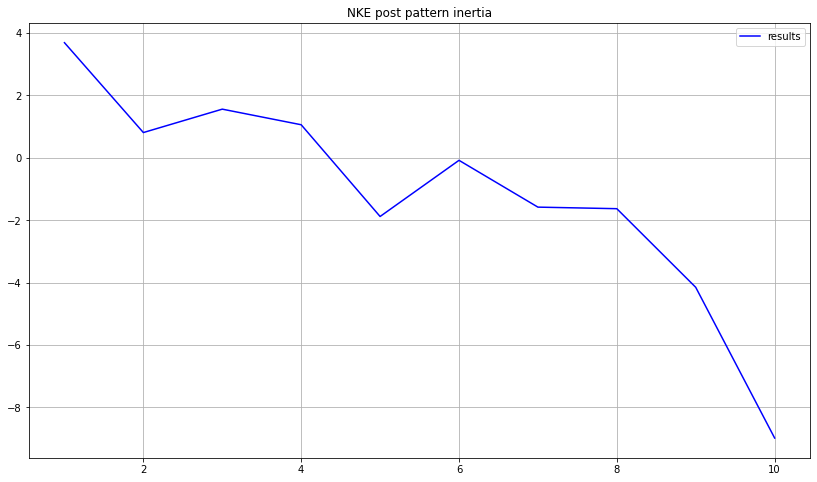


Pattern analysis on: PFE

Occurrences: 30 

DatetimeIndex(['2000-04-11', '2000-12-15', '2003-10-27', '2003-12-15',
               '2005-12-21', '2006-02-09', '2006-05-09', '2006-08-21',
               '2006-11-30', '2009-11-23', '2010-10-21', '2010-12-15',
               '2012-03-09', '2012-03-16', '2012-07-31', '2012-12-03',
               '2013-01-08', '2013-04-15', '2013-11-25', '2014-01-16',
               '2014-08-28', '2017-02-17', '2017-10-23', '2018-08-02',
               '2018-08-07', '2018-09-12', '2018-09-24', '2019-06-25',
               '2021-07-09', '2021-07-12'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -3.05 average of -0.1 with 11 winning trades and 19 loosing trades
After: 2 days: -1.47 average of -0.05 with 15 winning trades and 15 loosing trades
After: 3 days: 2.25 average of 0.08 with 16 winning trades and 14 loosing trades
After: 4 days: 2.69 average of 0.09 with 15 winning trades and 15 loosing trades
After: 5 days: 0.36 ave

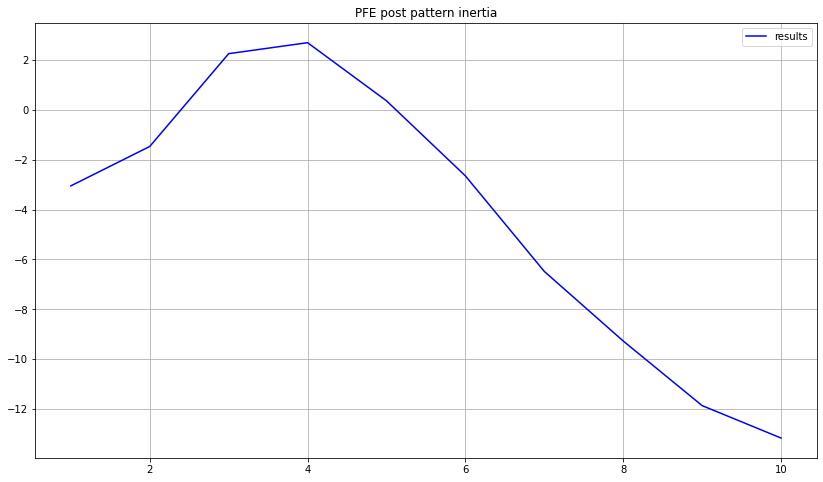


Pattern analysis on: XOM

Occurrences: 18 

DatetimeIndex(['2000-05-31', '2001-12-21', '2001-12-24', '2002-02-19',
               '2002-02-28', '2003-03-25', '2004-06-15', '2004-10-08',
               '2006-08-03', '2007-07-10', '2008-04-03', '2008-10-03',
               '2010-04-29', '2013-10-31', '2014-04-29', '2015-04-20',
               '2016-04-21', '2017-06-12'],
              dtype='datetime64[ns]', name='date', freq=None) 

After: 1 days: -3.92 average of -0.22 with 4 winning trades and 14 loosing trades
After: 2 days: -5.96 average of -0.33 with 4 winning trades and 14 loosing trades
After: 3 days: -9.12 average of -0.51 with 4 winning trades and 14 loosing trades
After: 4 days: -3.82 average of -0.21 with 6 winning trades and 12 loosing trades
After: 5 days: 7.63 average of 0.42 with 7 winning trades and 11 loosing trades
After: 6 days: -6.73 average of -0.37 with 6 winning trades and 12 loosing trades
After: 7 days: -8.39 average of -0.47 with 6 winning trades and 12 loosin

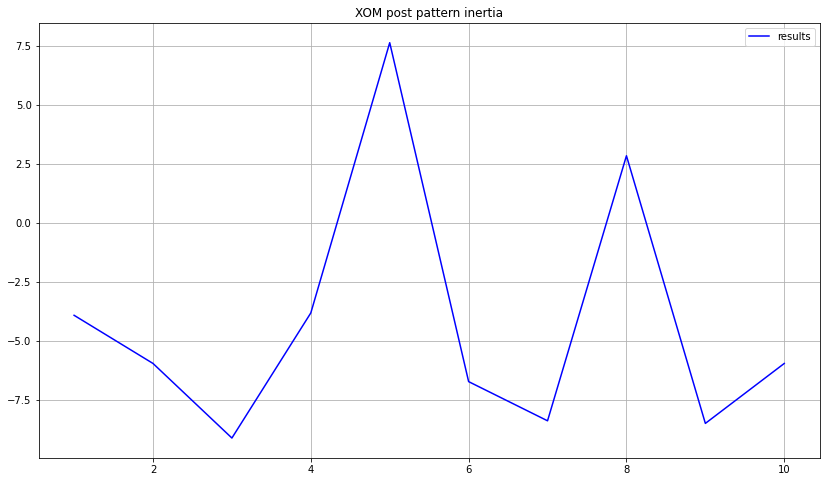


Basket analysis:
Positive inertia after 1 bars: ['AXP', 'BA', 'CVX', 'DIS', 'KO', 'HD', 'JPM', 'MMM', 'MSFT', 'NKE']
Positive inertia after 2 bars: ['AXP', 'BA', 'DIS', 'HD', 'IBM', 'JPM', 'MMM', 'MSFT', 'NKE']
Positive inertia after 3 bars: ['AXP', 'BA', 'CAT', 'CSCO', 'DIS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MMM', 'MSFT', 'NKE', 'PFE']
Positive inertia after 4 bars: ['BA', 'CAT', 'CSCO', 'DIS', 'IBM', 'INTC', 'JNJ', 'JPM', 'MMM', 'NKE', 'PFE']
Positive inertia after 5 bars: ['BA', 'CAT', 'CSCO', 'DIS', 'IBM', 'JNJ', 'JPM', 'MMM', 'MSFT', 'PFE', 'XOM']
Positive inertia after 6 bars: ['BA', 'CAT', 'CSCO', 'DIS', 'IBM', 'JNJ', 'JPM', 'MMM']
Positive inertia after 7 bars: ['BA', 'CAT', 'CSCO', 'DIS', 'IBM', 'JNJ', 'JPM', 'MMM']
Positive inertia after 8 bars: ['AXP', 'BA', 'CAT', 'CSCO', 'DIS', 'IBM', 'JNJ', 'JPM', 'MMM', 'XOM']
Positive inertia after 9 bars: ['AXP', 'BA', 'CSCO', 'IBM', 'JNJ', 'JPM']
Positive inertia after 10 bars: ['AXP', 'CSCO', 'IBM', 'JNJ', 'JPM', 'MMM']


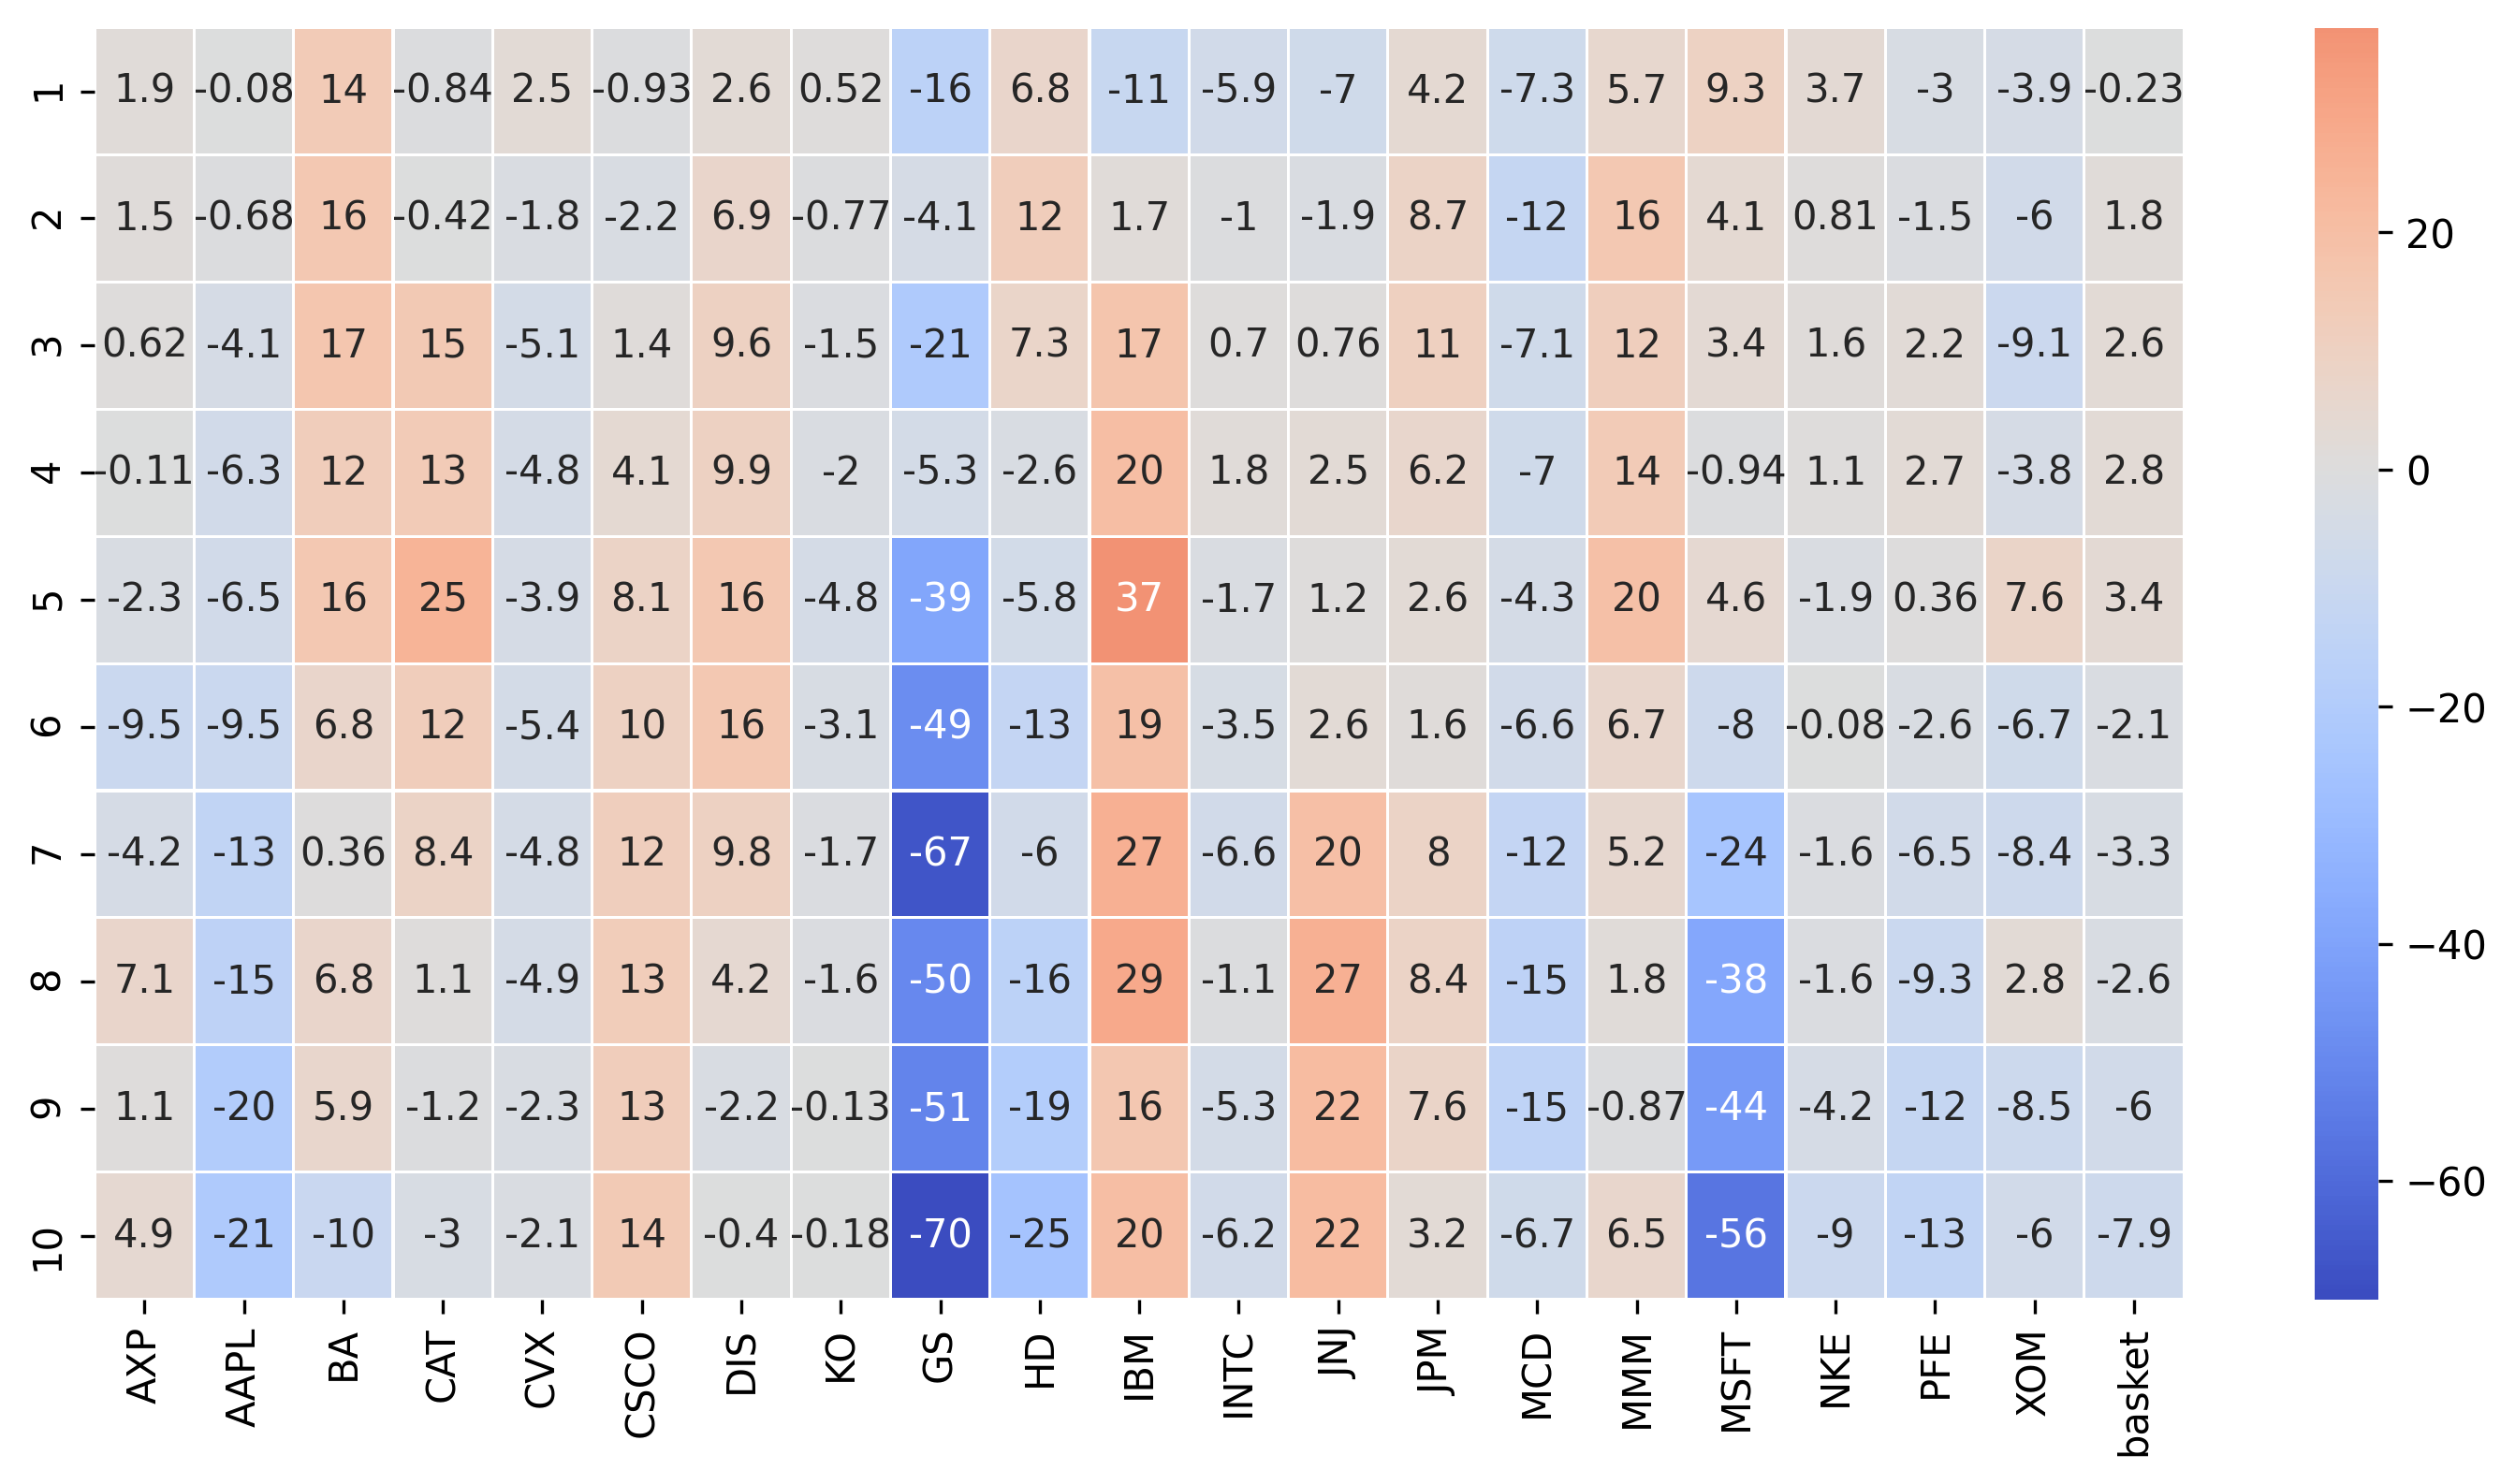

In [43]:
basket_results = pd.DataFrame(index = range(1,days_after + 1))

for ticker in tickerlist:

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    pattern = (dataset.high > dataset.BBU) & (dataset.close < dataset.BBU) & \
              (dataset.close_pos < 30) & (dataset.open_pos < 30) & (dataset.range_perc > 1)
    
    results = pattern_stats(dataset, pattern, "short", days_after, ticker)
    
    if show_patterns == True:
        plot_patterns(dataset,results[0])
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [44]:
basket_results.iplot(title = "Pattern inertia")